# Missoula (KMSO)

In [1]:
import archive
from project_utilities import normalize_var, get_monthly_average_data

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from datetime import datetime

%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.1.5


In [2]:
arch = archive.Archive()
start = datetime(1948, 1, 1)
end = datetime(2021, 12, 31)

Archive root is /home/ryan/programming/bayes-trends/default_archive
Connected to /home/ryan/programming/bayes-trends/default_archive/obs.db


## June through October Average Vapor Pressure Deficit

I use June through October for a couple reasons. First, some have claimed that fire season is getting longer, and if that is the case it may show up as a higher VPD in the shoulder seasons of June and October. This period also covers all of the fire season.

In [3]:
# Load the data
data = get_monthly_average_data(arch, 'kmso', months=(6, 7, 8, 9, 10), starting=start, ending=end)
df = pd.DataFrame(data, columns=["year", "avg_t", "avg_td", "avg_vpd"])

x_norm, x_denorm = normalize_var(df, 'year', 'x_obs')
y_t_norm, y_t_denorm = normalize_var(df, 'avg_t', 'y_t_obs')
y_td_norm, y_td_denorm = normalize_var(df, 'avg_td', 'y_td_obs')
y_vpd_norm, y_vpd_denorm = normalize_var(df, 'avg_vpd', 'y_vpd_obs')

df


year offset = 1986.2923076923078 scale = 22.12586373802944


avg_t offset = 14.98094202939242 scale = 0.9193346943251459


avg_td offset = 4.96213039538763 scale = 0.9800441890260516


avg_vpd offset = 10.122166144364755 scale = 1.5760275988019767



,year,avg_t,avg_td,avg_vpd,x_obs,y_t_obs,y_td_obs,y_vpd_obs
0,1948,13.959967,5.887335,7.925192,-1.730658,-1.110558,0.944044,-1.393994
1,1949,14.641068,3.231292,10.937600,-1.685462,-0.369696,-1.766082,0.517398
2,1950,14.398148,5.665514,8.790989,-1.640266,-0.633930,0.717706,-0.844641
3,1951,13.967593,4.843905,8.935208,-1.595070,-1.102264,-0.120633,-0.753133
4,1952,15.265523,3.738485,10.833384,-1.549874,0.309551,-1.248561,0.451273
...,...,...,...,...,...,...,...,...
60,2017,16.062449,4.098723,12.563685,1.387864,1.176402,-0.880988,1.549160
61,2018,14.932153,4.130986,10.585693,1.433060,-0.053070,-0.848068,0.294111
62,2019,14.661123,4.923849,9.890422,1.478256,-0.347881,-0.039061,-0.147043
63,2020,15.159159,5.320374,10.446773,1.523452,0.193854,0.365538,0.205965


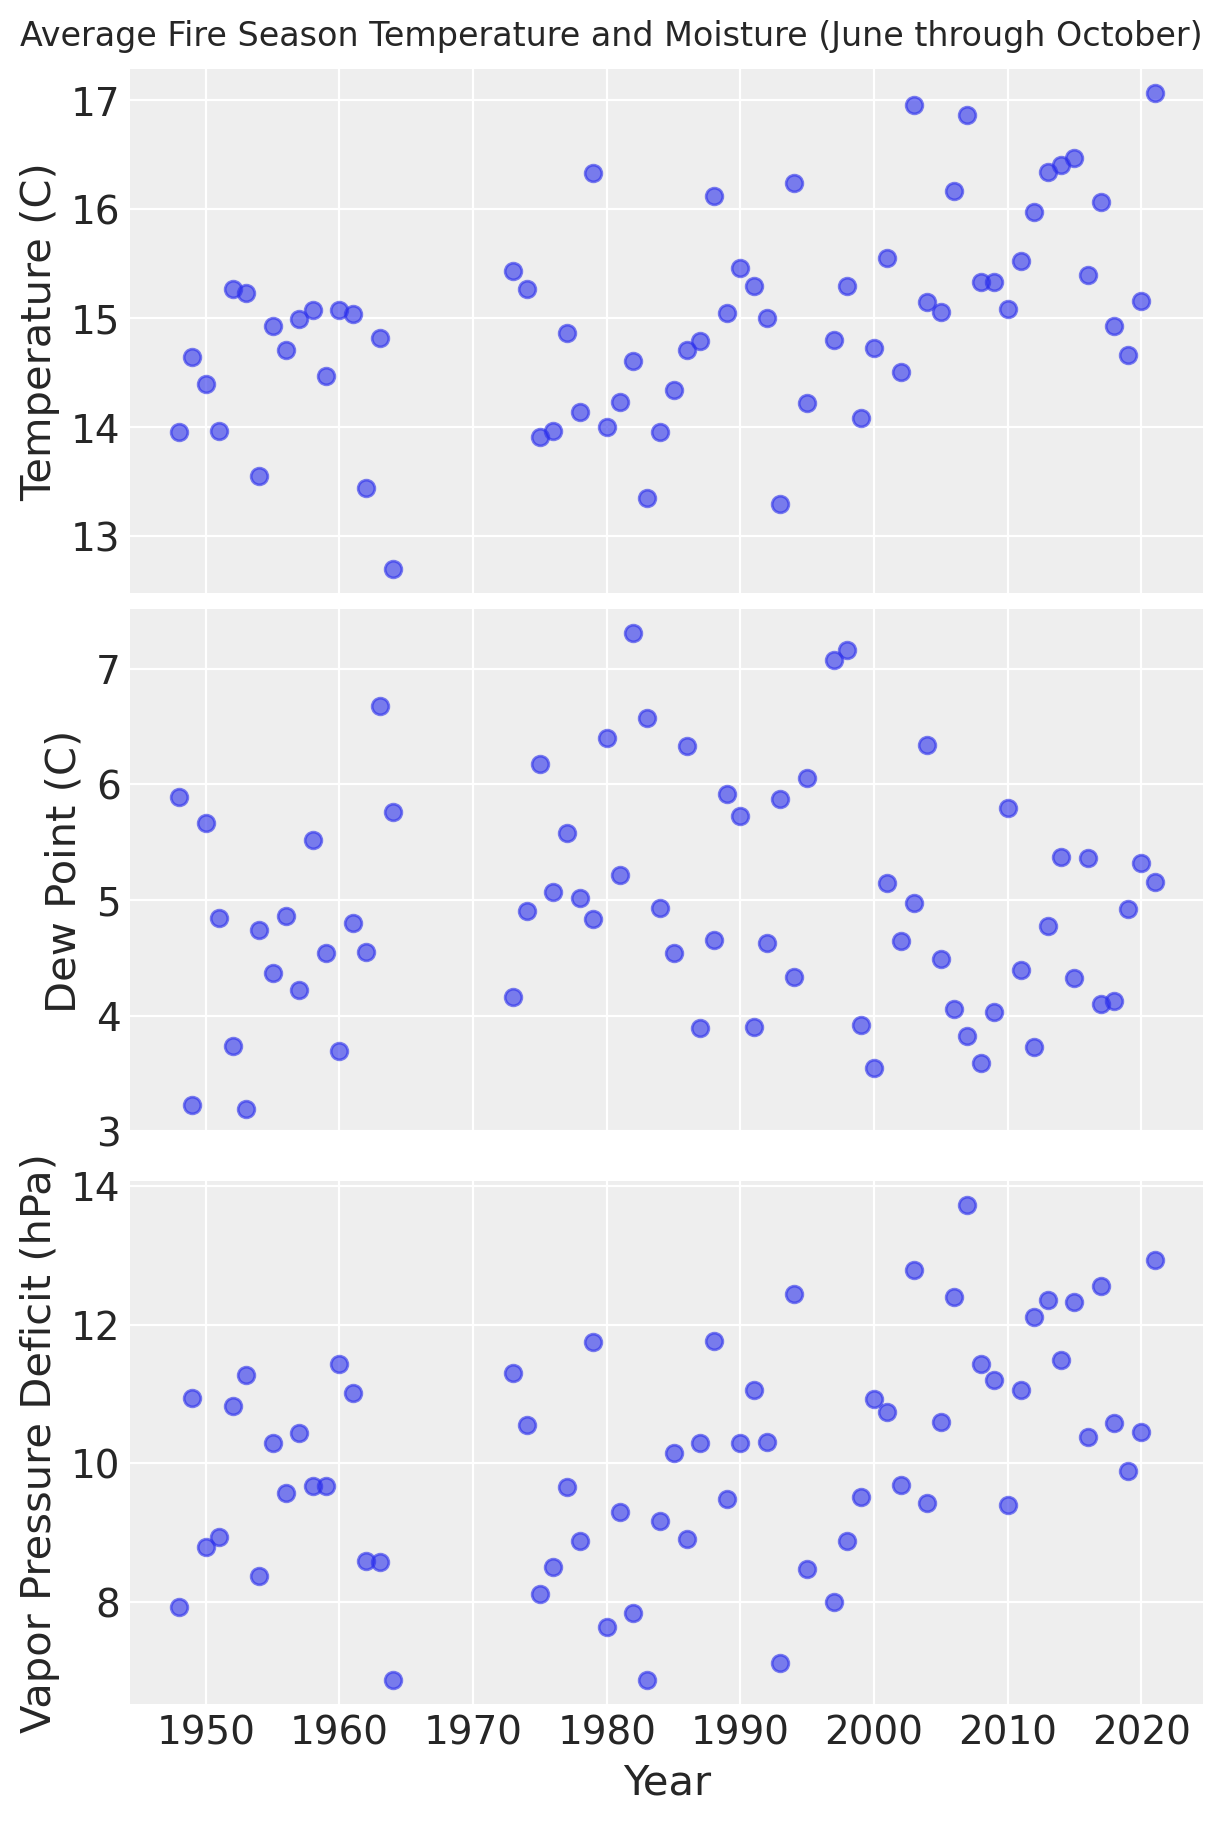

In [23]:
fig, (ax_t, ax_td, ax_vpd) = plt.subplots(3, 1, sharex=True, figsize=(6,9));
fig.suptitle('Average Fire Season Temperature and Moisture (June through October)');

ax_t.scatter(x_denorm(df['x_obs']), y_t_denorm(df['y_t_obs']), alpha=0.6);
ax_t.set_ylabel('Temperature (C)');

ax_td.scatter(x_denorm(df['x_obs']), y_td_denorm(df['y_td_obs']), alpha=0.6);
ax_td.set_ylabel('Dew Point (C)');

ax_vpd.scatter(x_denorm(df['x_obs']), y_vpd_denorm(df['y_vpd_obs']), alpha=0.6);
ax_vpd.set_ylabel('Vapor Pressure Deficit (hPa)');
ax_vpd.set_xlabel('Year');

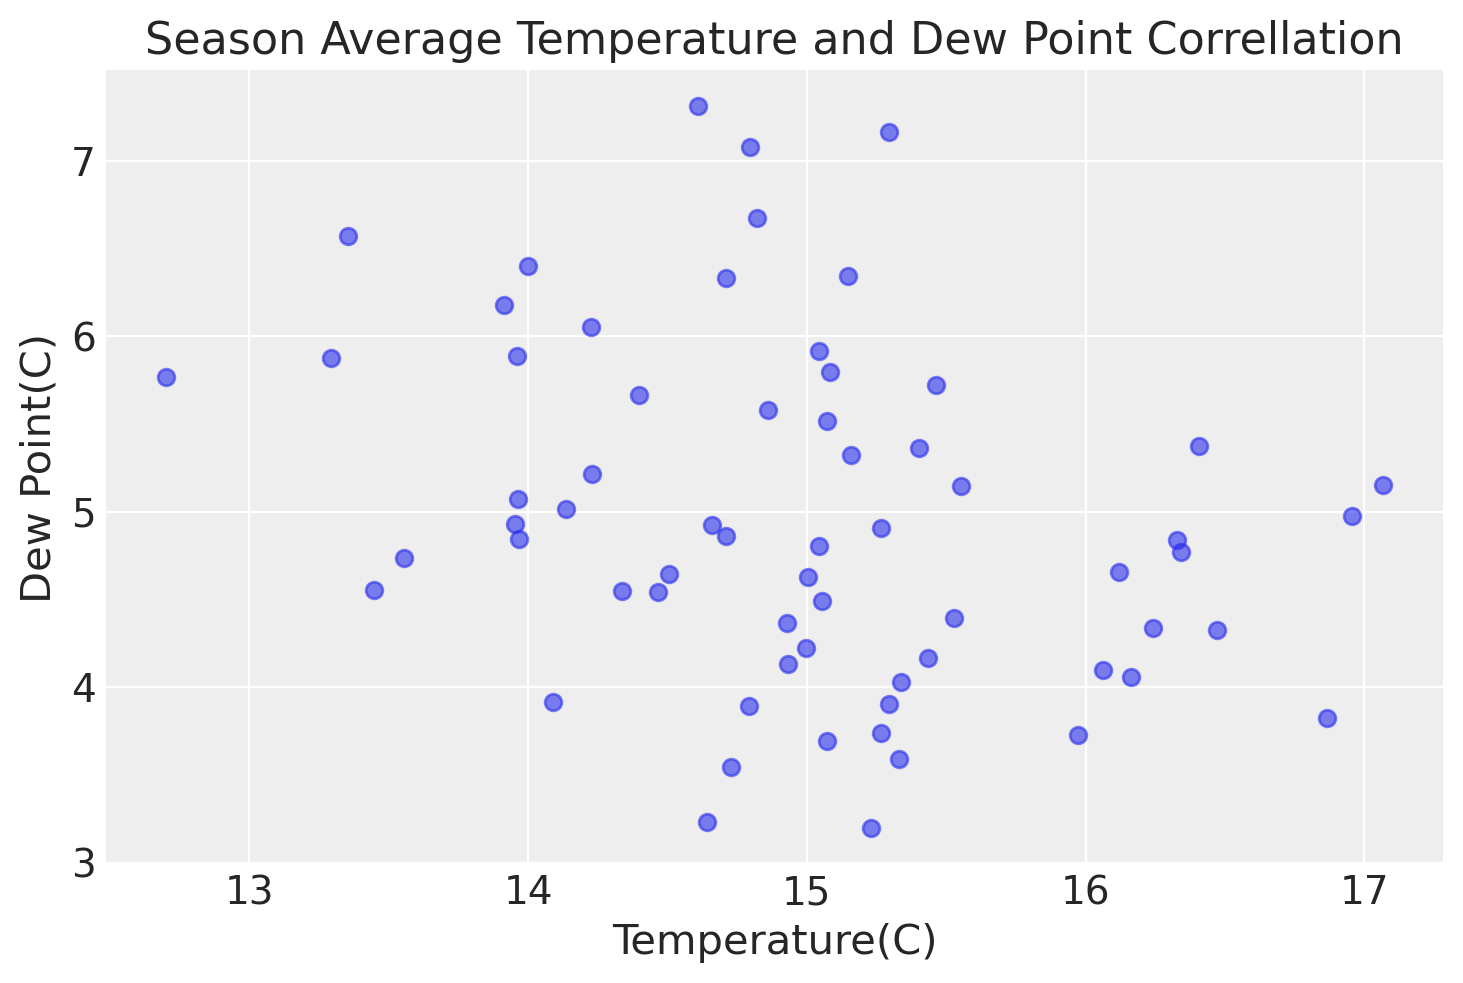

In [26]:
plt.scatter(y_t_denorm(df['y_t_obs']),y_td_denorm(df['y_td_obs']), alpha=0.6);
plt.xlabel("Temperature(C)");
plt.ylabel("Dew Point(C)");
plt.title("Season Average Temperature and Dew Point Correllation");

In [5]:
x_future = x_norm(xr.DataArray(range(2022,2036)))

linear_t_model = pm.Model()
with linear_t_model:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    nu = pm.Exponential('nu', lam=1)
    
    # Set predictors as shared variable to change them fo PPC
    pred = pm.MutableData("pred", df['x_obs'])
    mu = alpha + beta * pred
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.StudentT('Y_obs', mu=mu, sigma=sigma, nu=nu, observed=df['y_t_obs'])

    idata_t = pm.sample(2000, tune=2000, return_inferencedata=True)
    

linear_td_model = pm.Model()
with linear_td_model:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    nu = pm.Exponential('nu', lam=1)
    
    # Set predictors as shared variable to change them fo PPC
    pred = pm.MutableData("pred", df['x_obs'])
    mu = alpha + beta * pred
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.StudentT('Y_obs', mu=mu, sigma=sigma, nu=nu, observed=df['y_td_obs'])

    idata_td = pm.sample(2000, tune=2000, return_inferencedata=True)
    

linear_vpd_model = pm.Model()
with linear_vpd_model:
    
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma = pm.Exponential('sigma', lam=1)
    nu = pm.Exponential('nu', lam=1)
    
    # Set predictors as shared variable to change them fo PPC
    pred = pm.MutableData("pred", df['x_obs'])
    mu = alpha + beta * pred
    
    # Likelihood (sampling distribution) of observations
    Y_obs = pm.StudentT('Y_obs', mu=mu, sigma=sigma, nu=nu, observed=df['y_vpd_obs'])

    idata_vpd = pm.sample(2000, tune=2000, return_inferencedata=True)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 6 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma, nu]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.


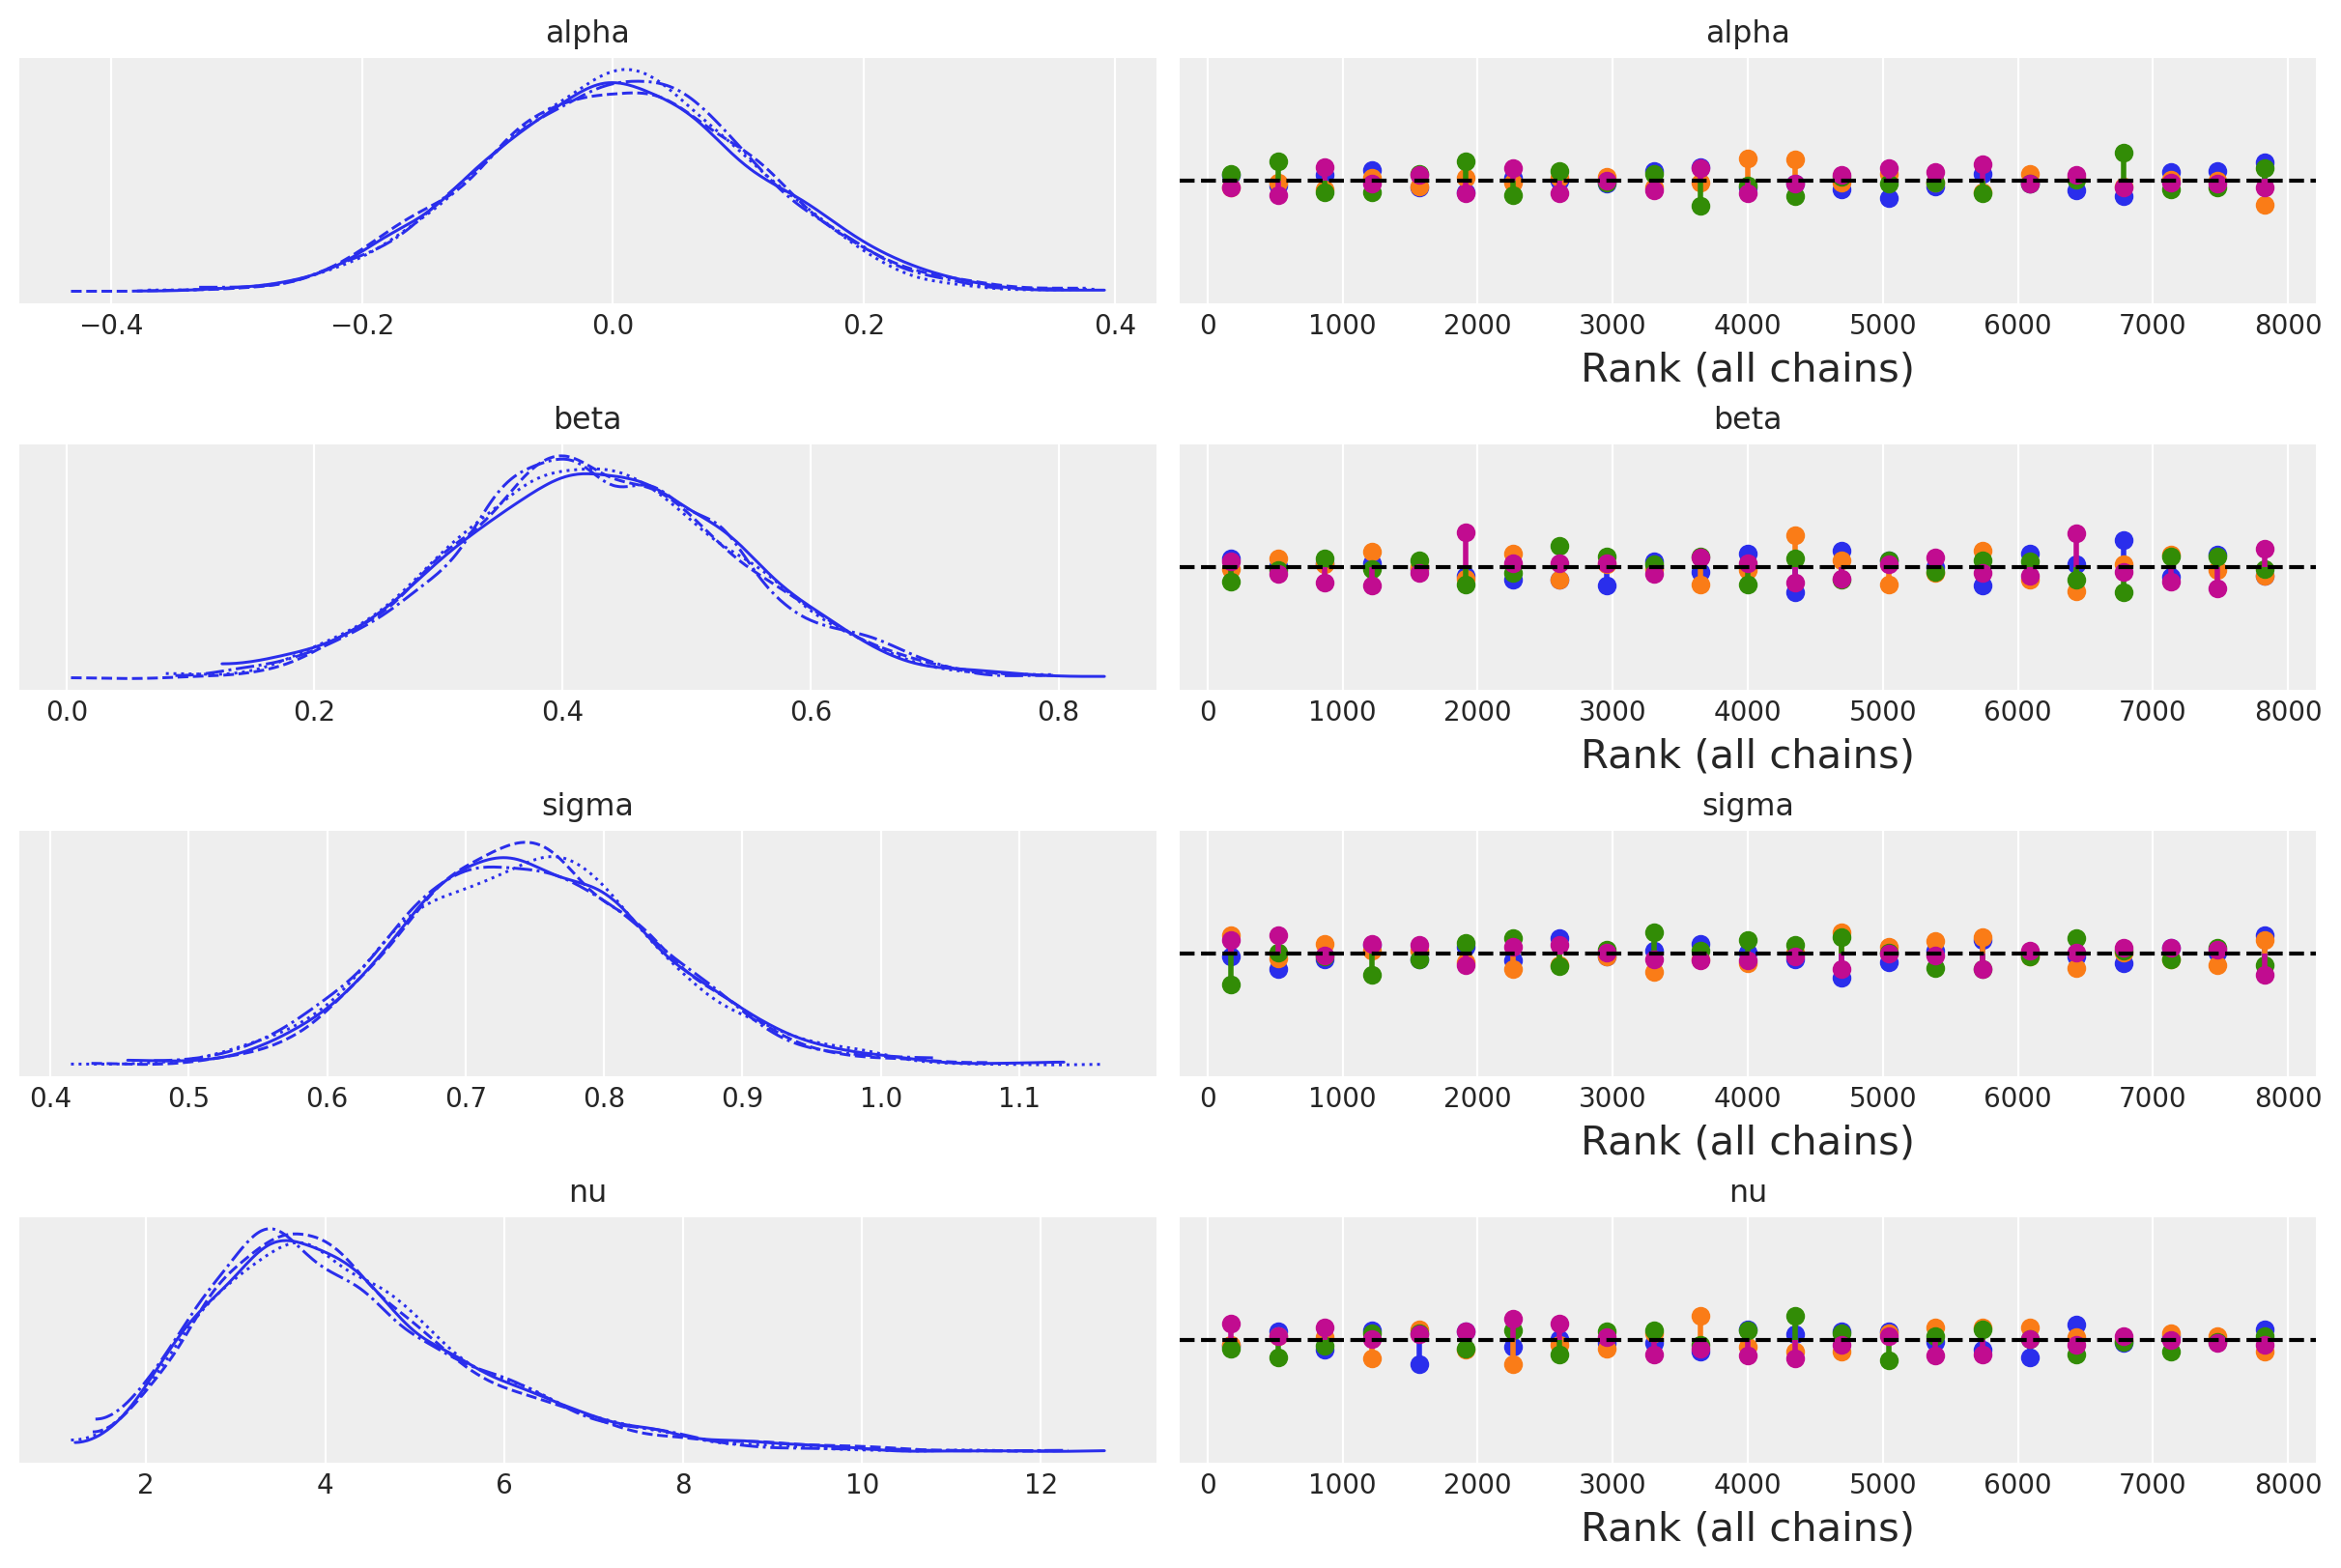

In [6]:
az.plot_trace(idata_t, kind='rank_vlines');

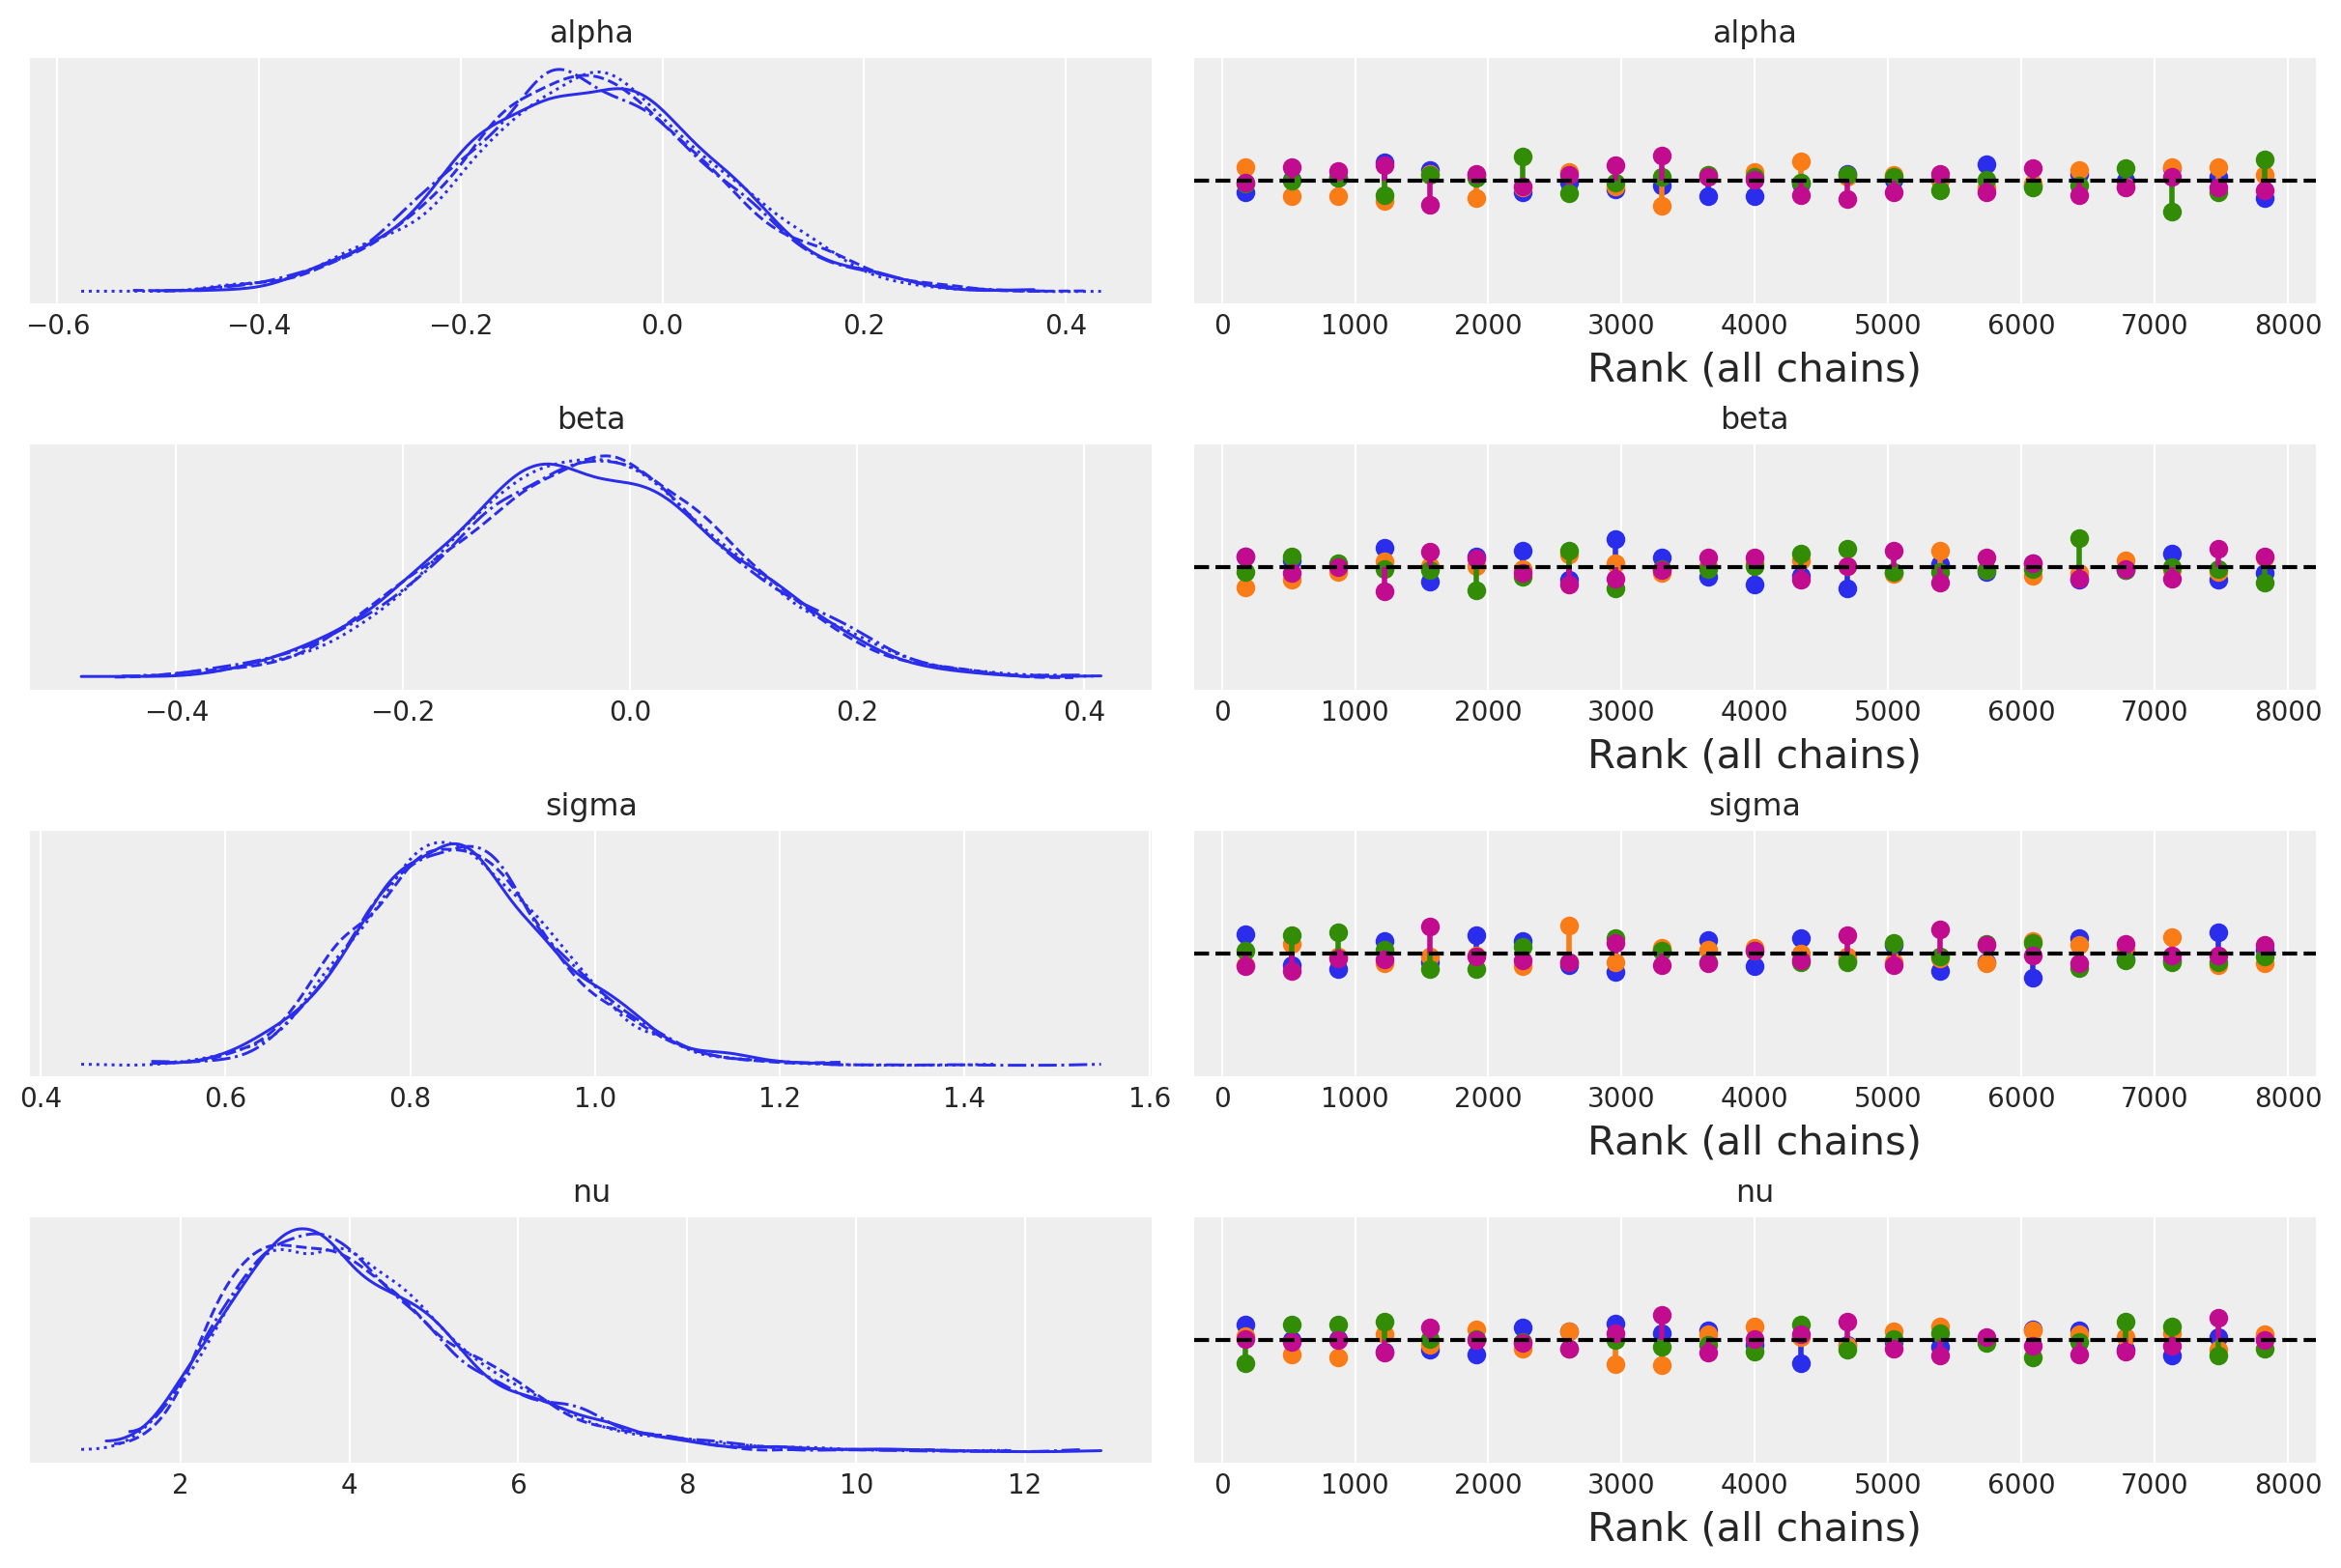

In [7]:
az.plot_trace(idata_td, kind='rank_vlines');

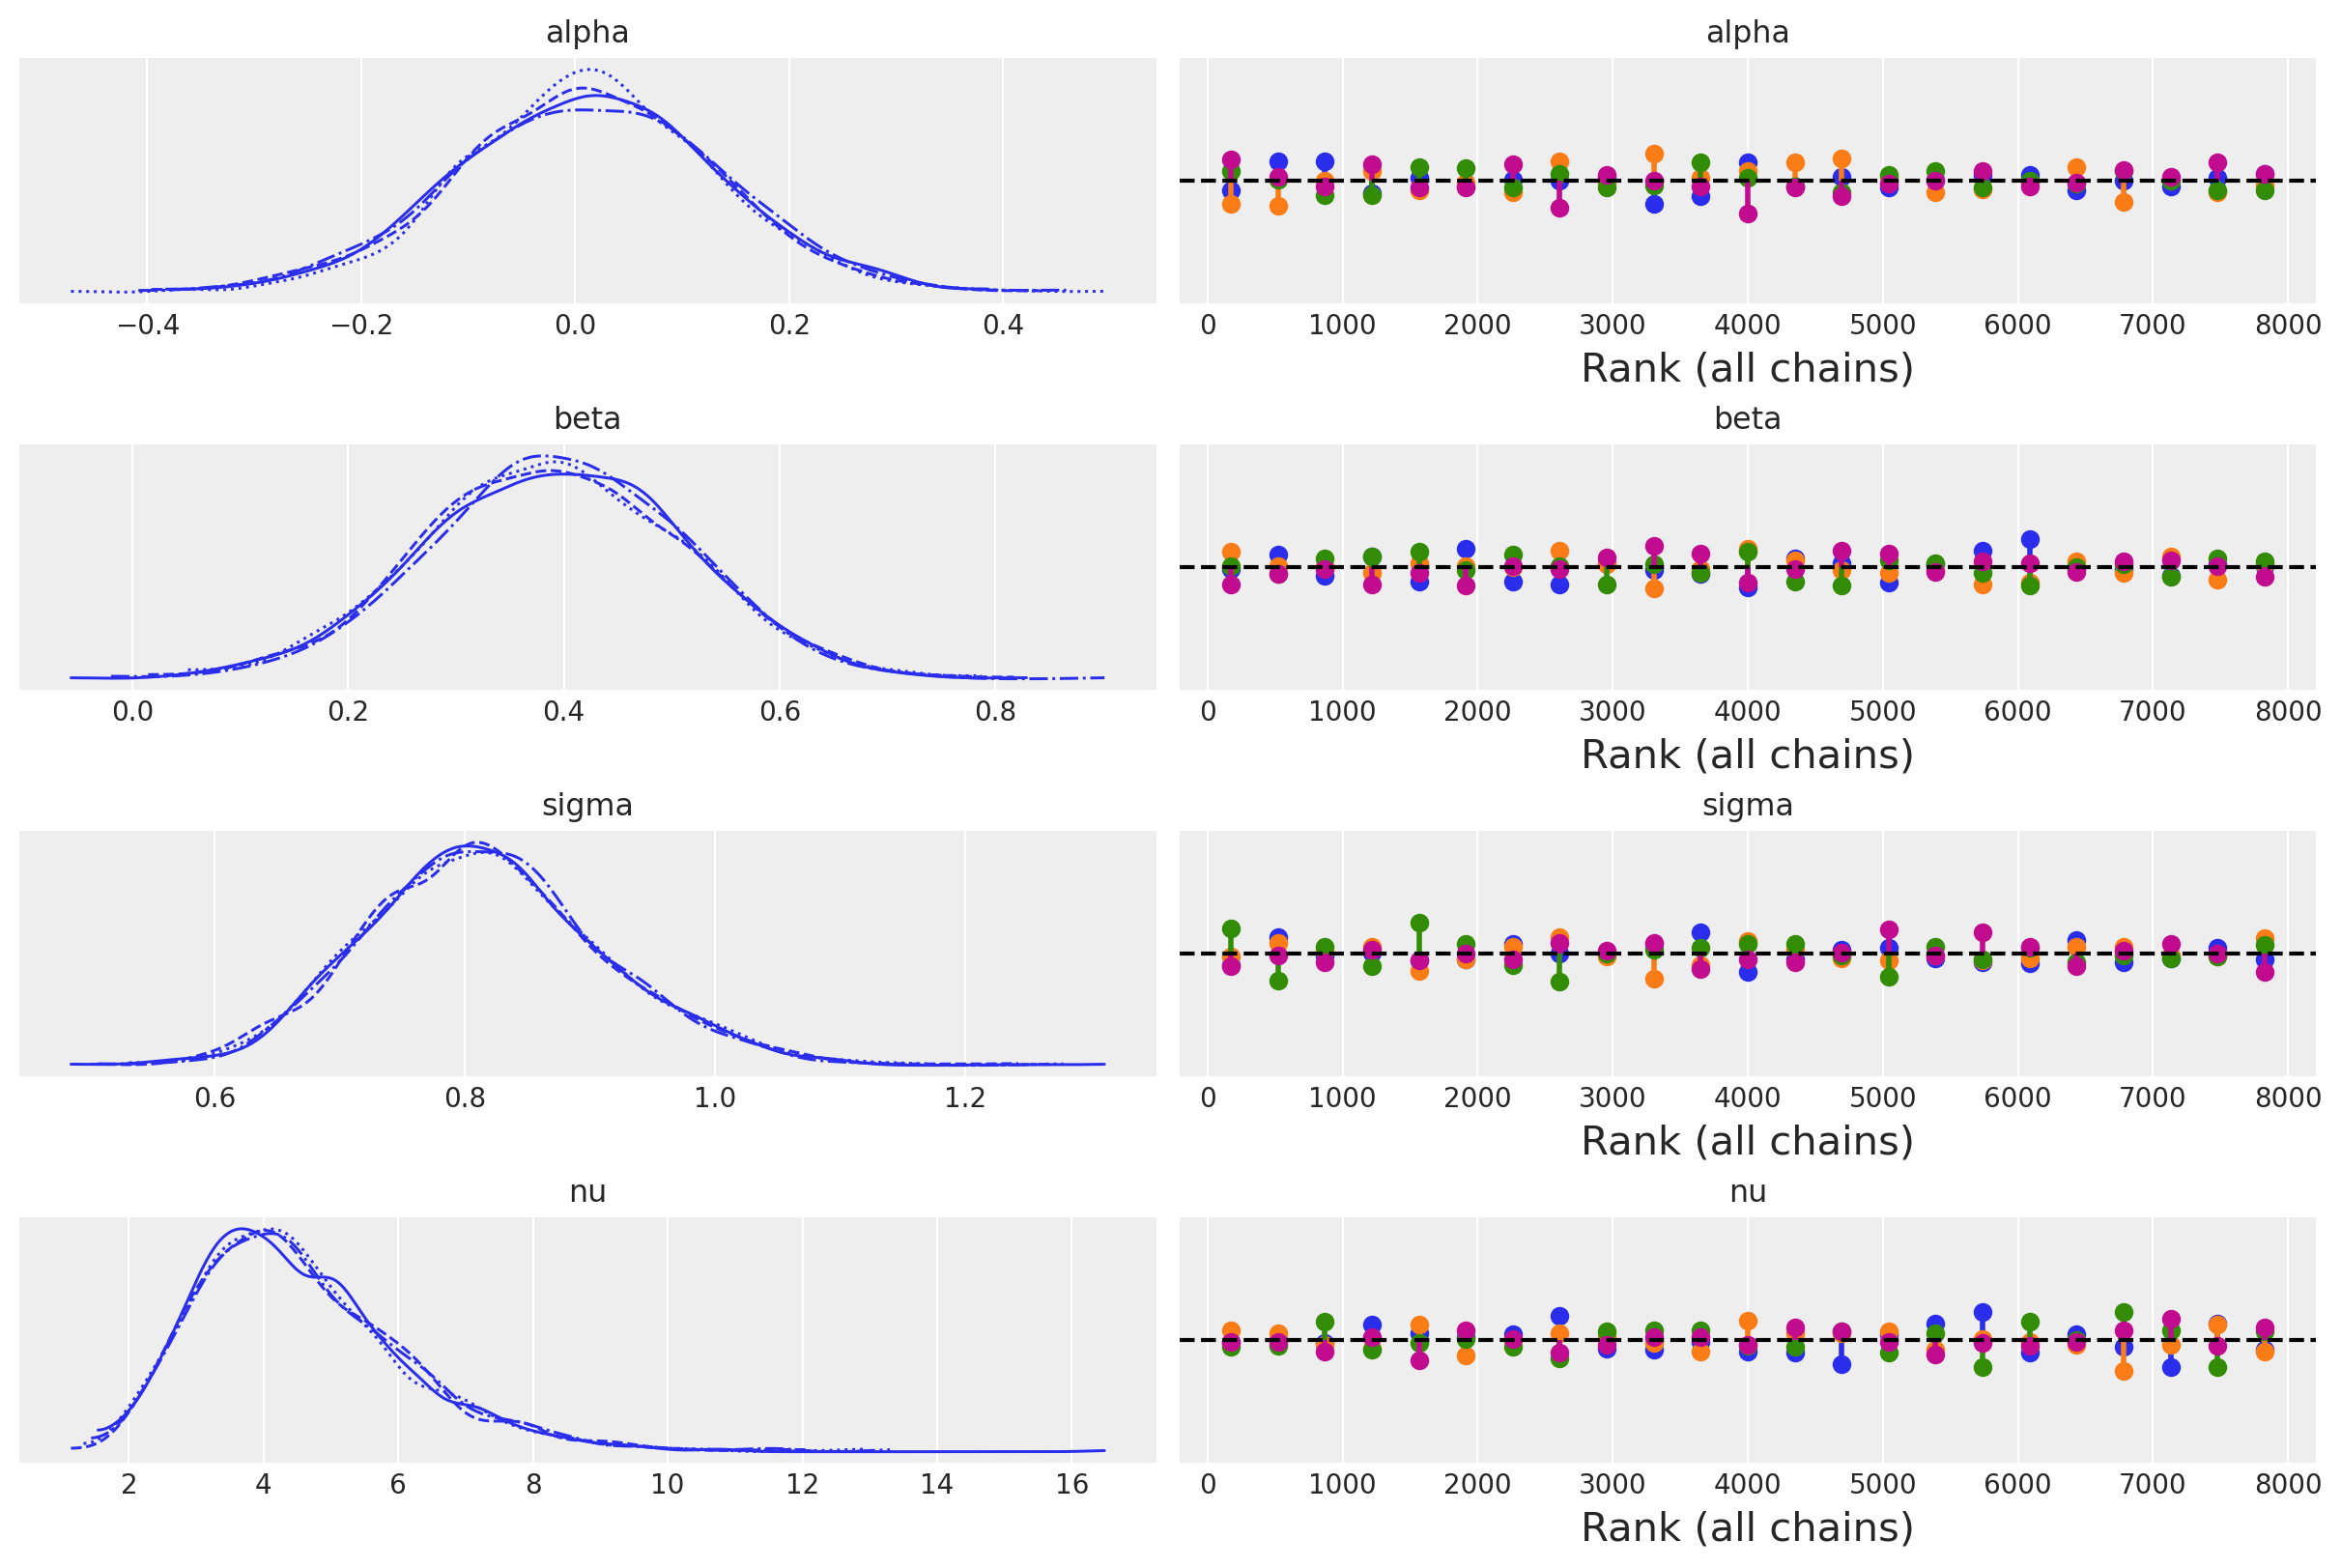

In [8]:
az.plot_trace(idata_vpd, kind='rank_vlines');

In [9]:
az.summary(idata_t, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.006,0.109,-0.196,0.210,0.001,0.001,8350.330,6347.350,1.002
beta,0.428,0.113,0.217,0.642,0.001,0.001,9647.951,6553.225,1.000
sigma,0.747,0.093,0.581,0.927,0.001,0.001,7073.067,5275.579,1.001
nu,4.248,1.557,1.681,7.098,0.018,0.013,7025.897,6050.686,1.000


In [10]:
az.summary(idata_td, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.075,0.127,-0.320,0.163,0.001,0.001,10439.216,6327.568,1.000
beta,-0.035,0.126,-0.267,0.203,0.001,0.001,8880.887,5938.409,1.001
sigma,0.853,0.107,0.651,1.049,0.001,0.001,6431.481,5196.245,1.001
nu,4.127,1.471,1.786,6.877,0.017,0.012,7049.969,6221.406,1.000


In [11]:
az.summary(idata_vpd, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.012,0.122,-0.223,0.238,0.001,0.001,12581.068,6207.631,1.002
beta,0.392,0.120,0.171,0.619,0.001,0.001,11351.958,6788.123,1.000
sigma,0.817,0.095,0.641,0.997,0.001,0.001,7722.386,6583.394,1.001
nu,4.558,1.569,1.944,7.466,0.017,0.012,8534.489,6670.881,1.000


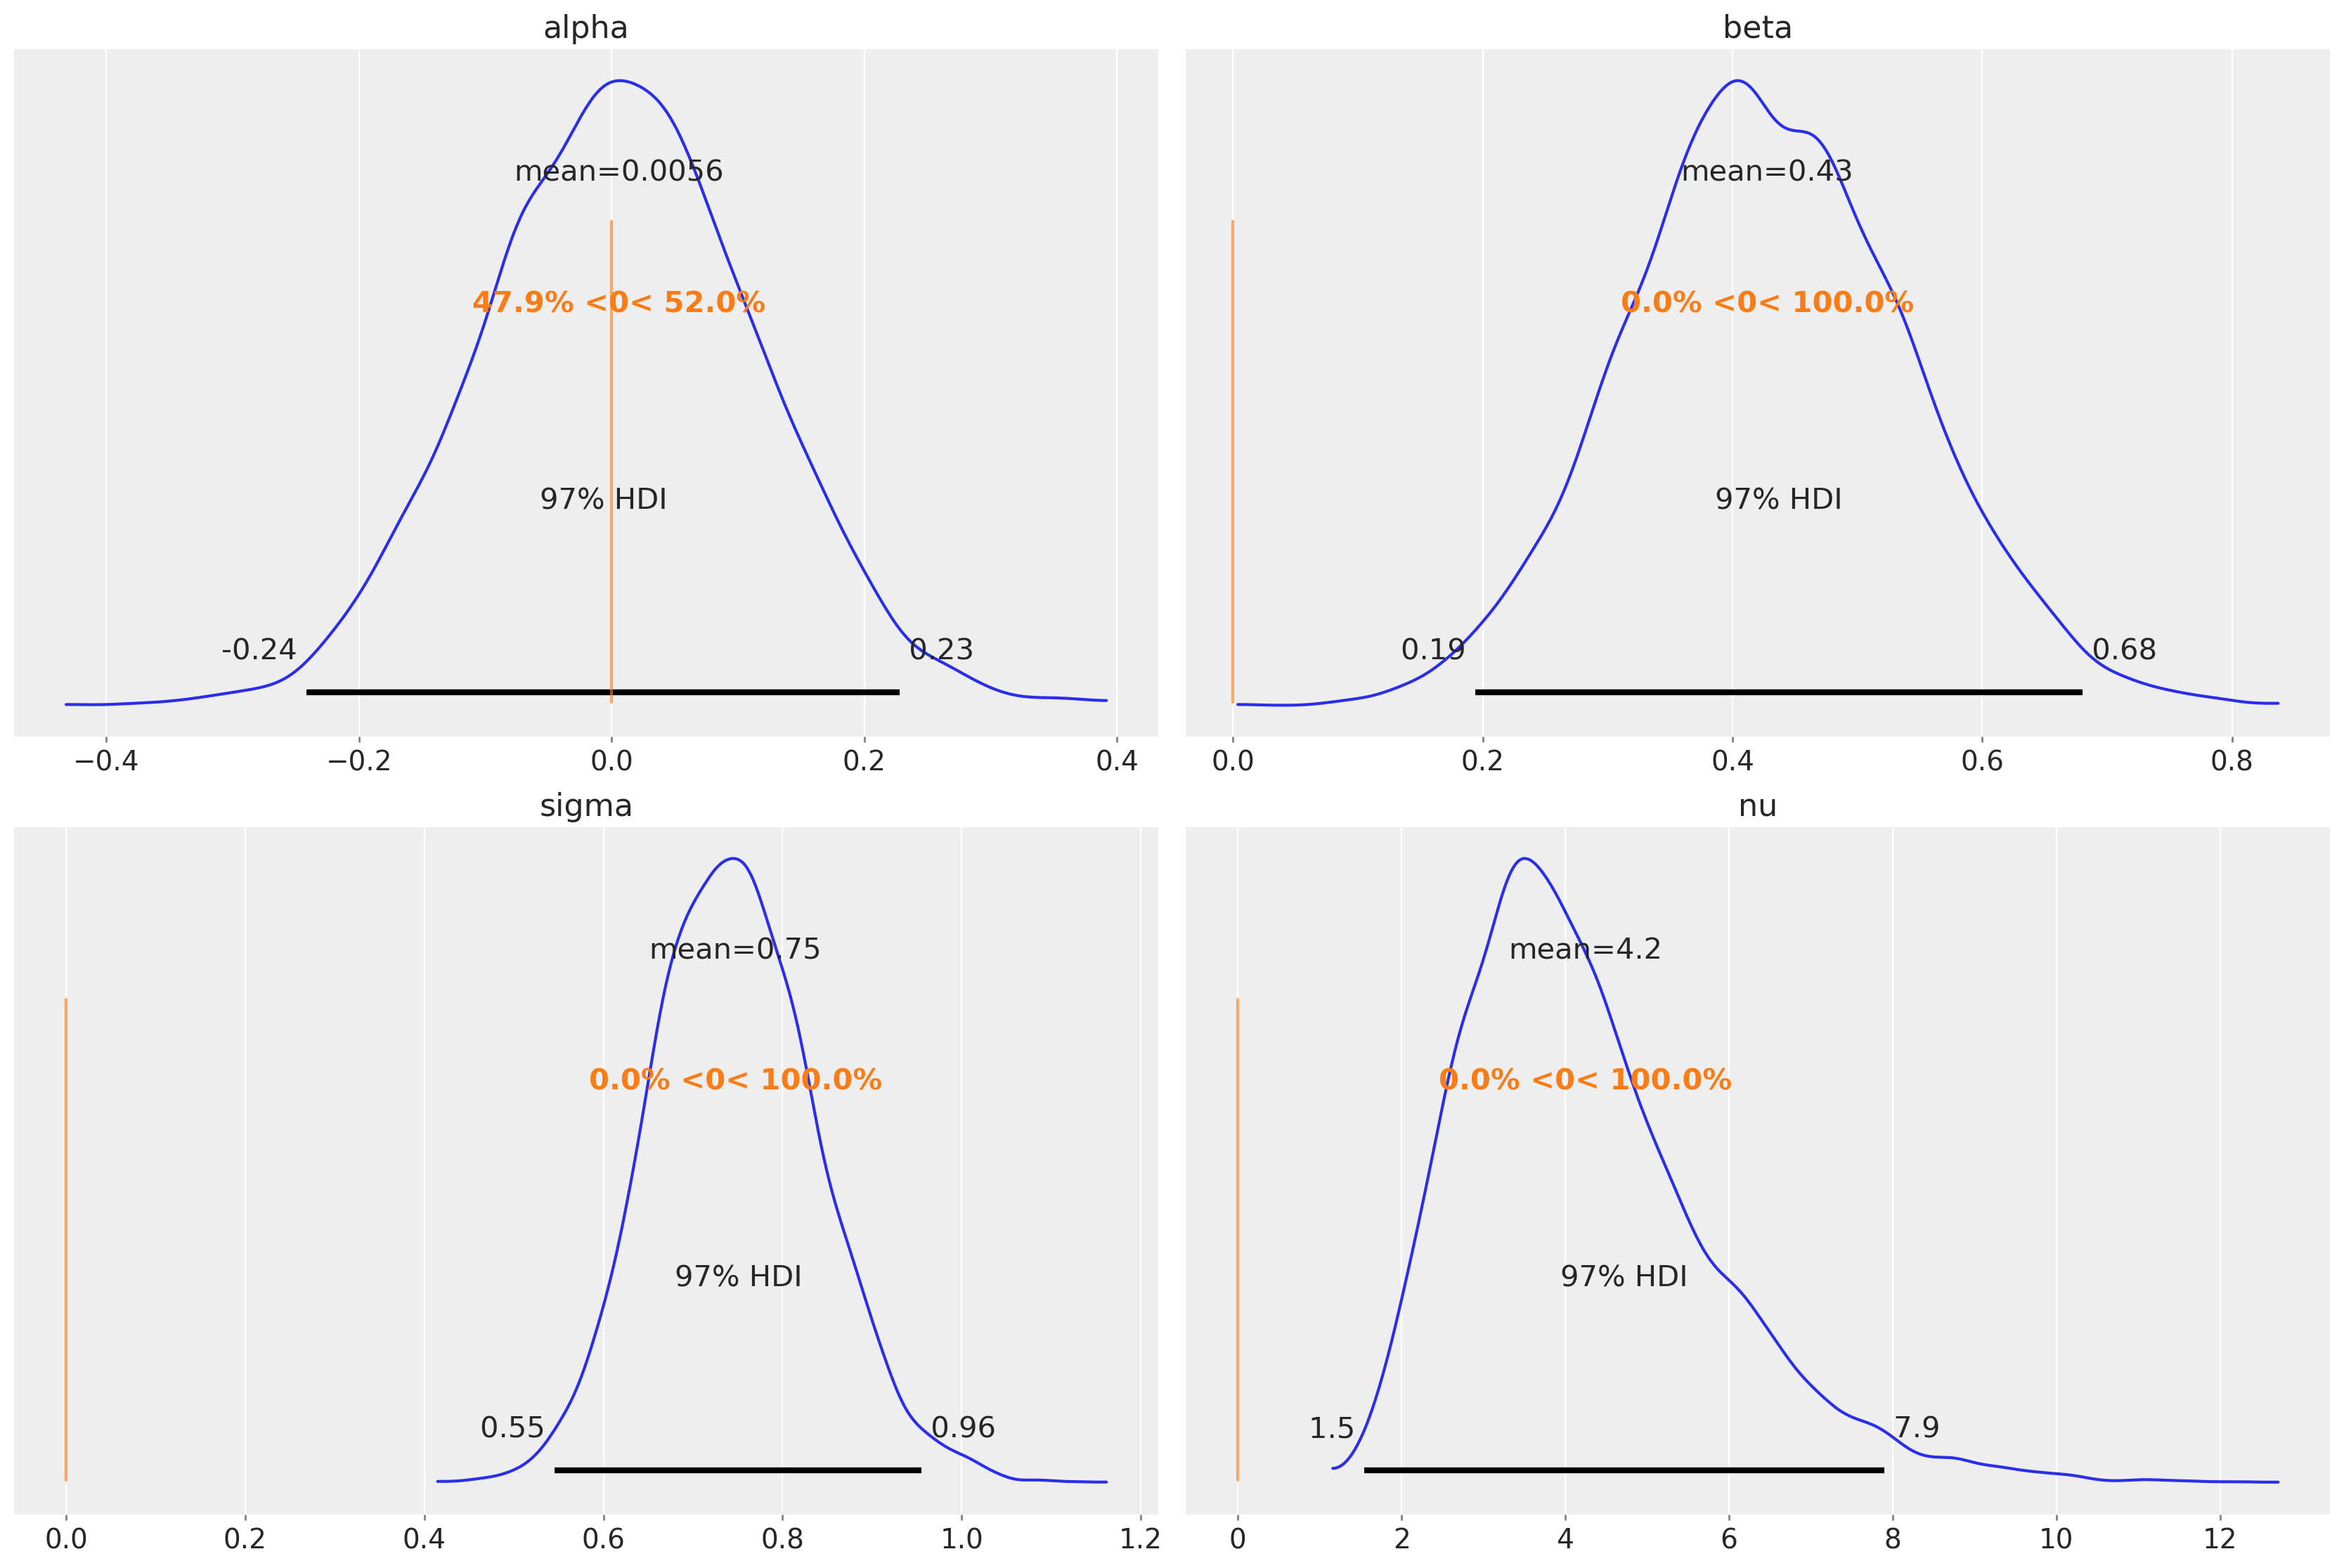

In [12]:
az.plot_posterior(idata_t, grid=(2,2), hdi_prob=0.97, ref_val=0.0);

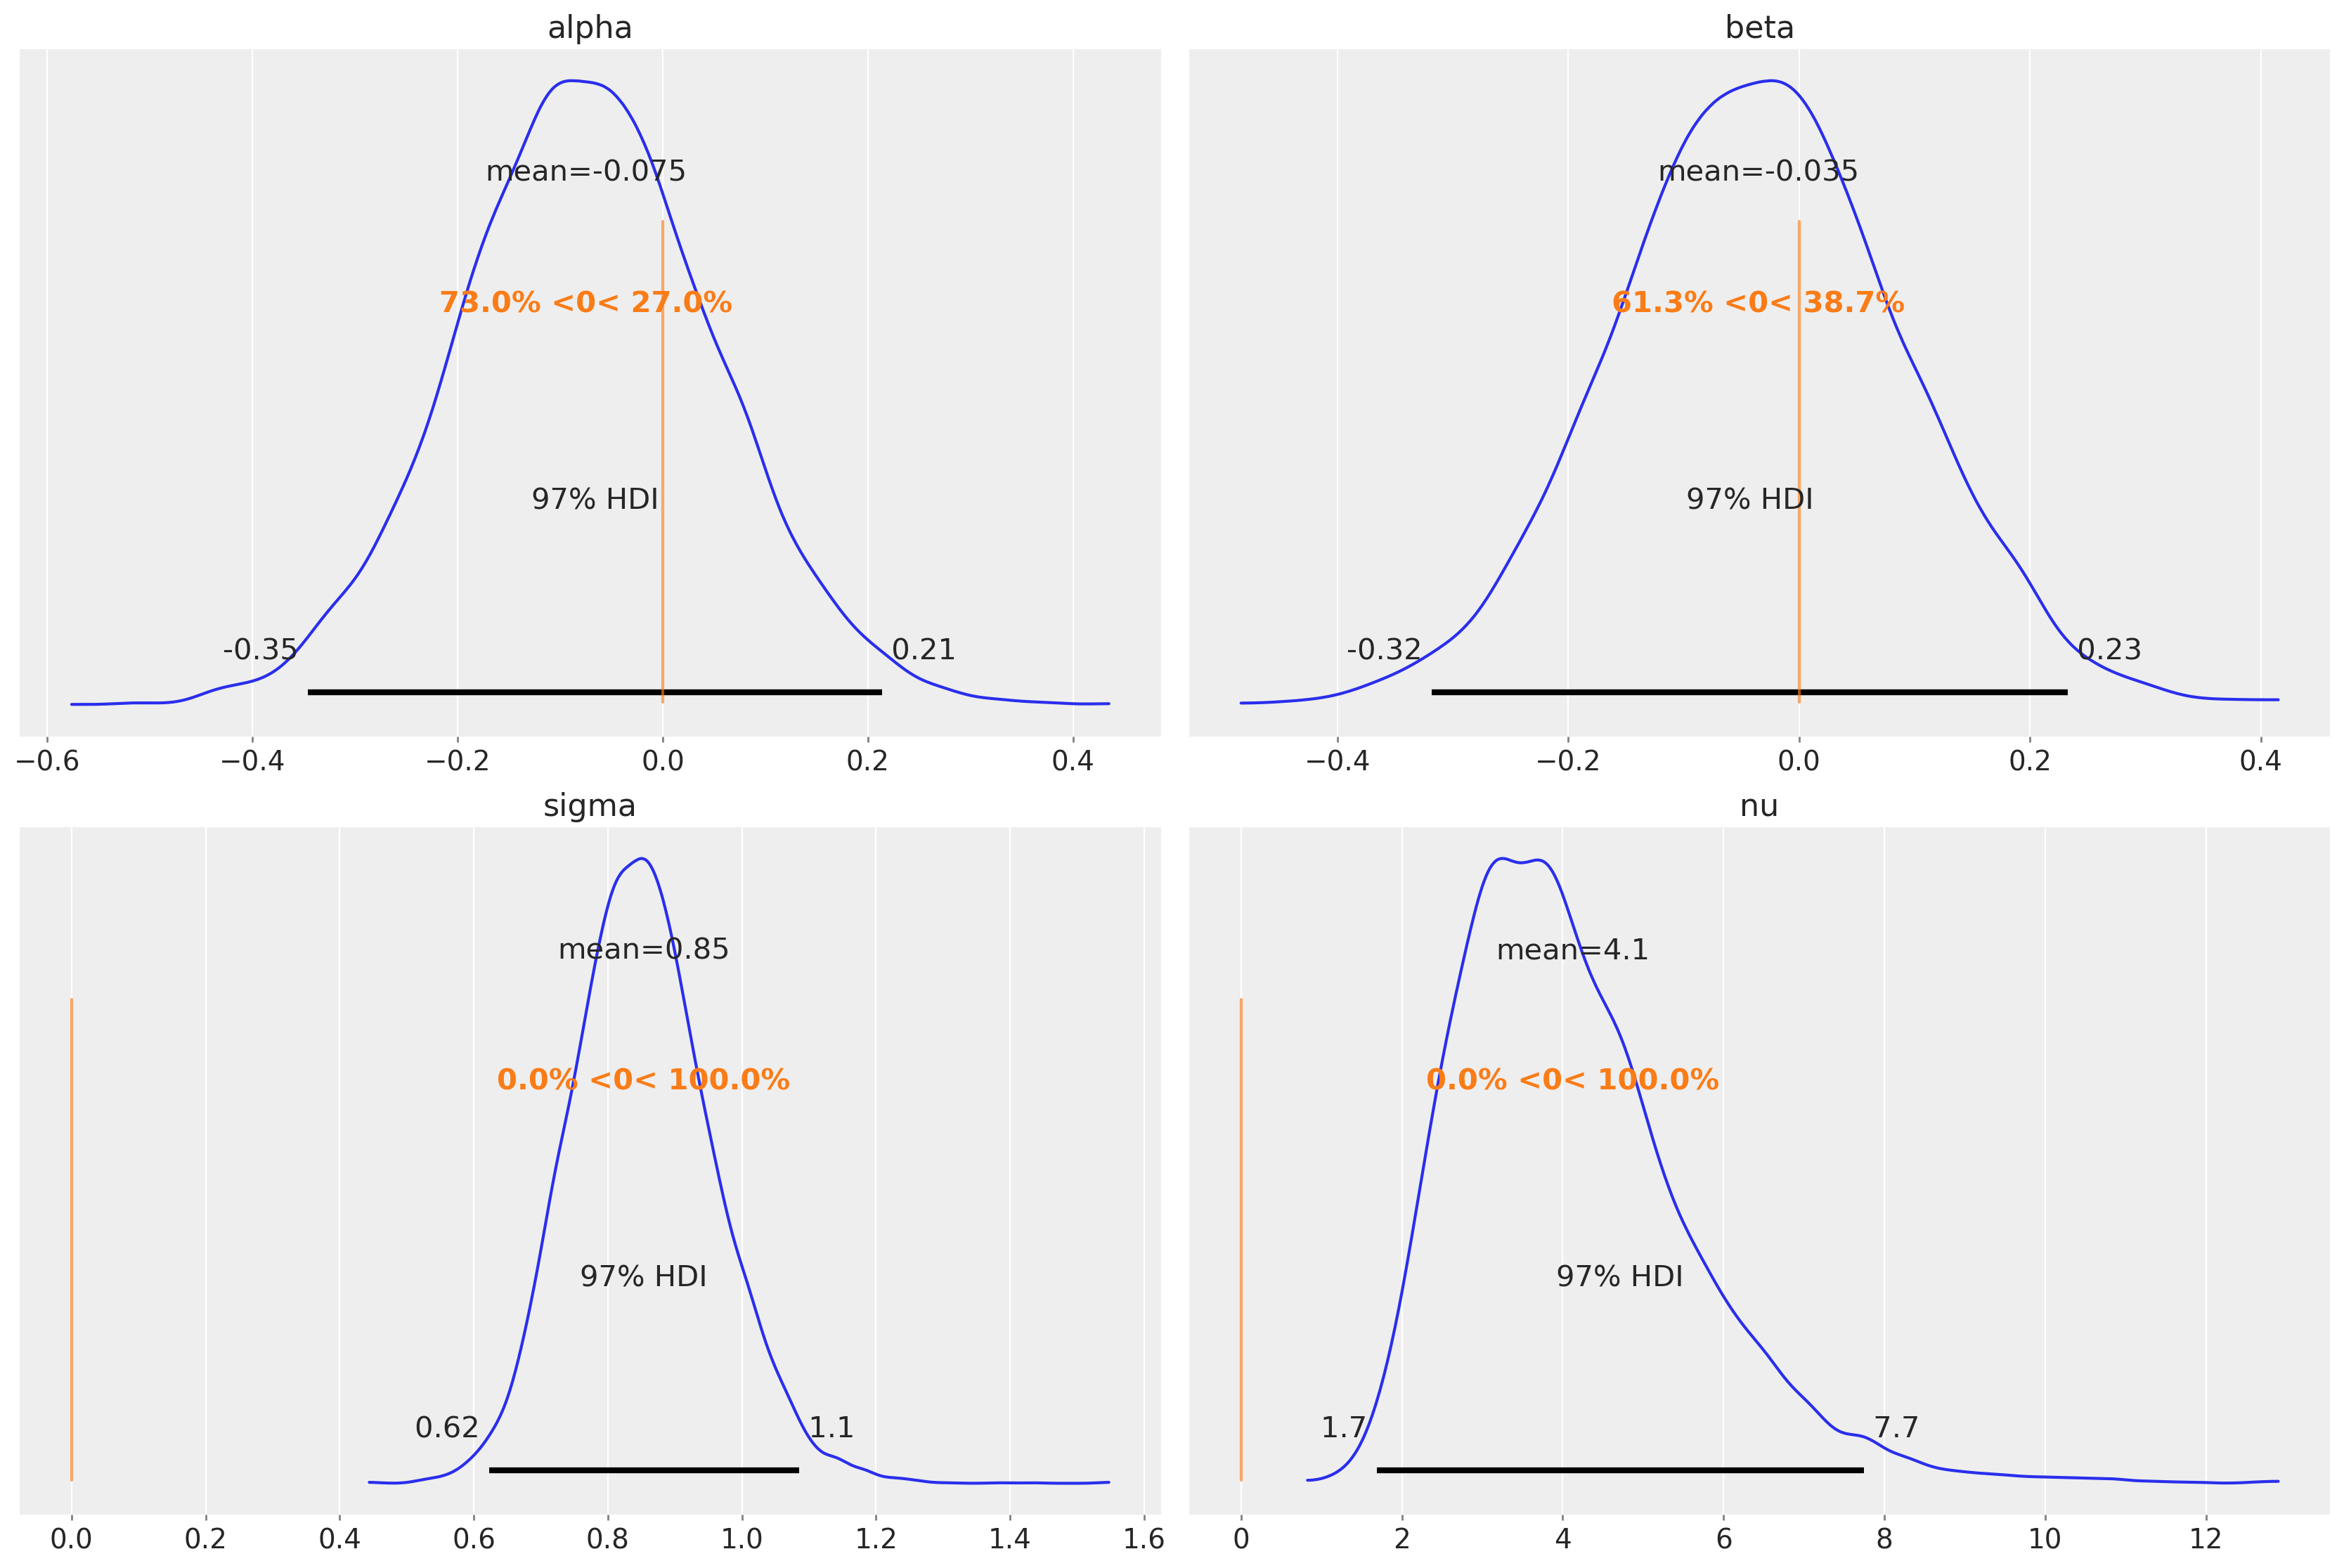

In [13]:
az.plot_posterior(idata_td, grid=(2,2), hdi_prob=0.97, ref_val=0.0);

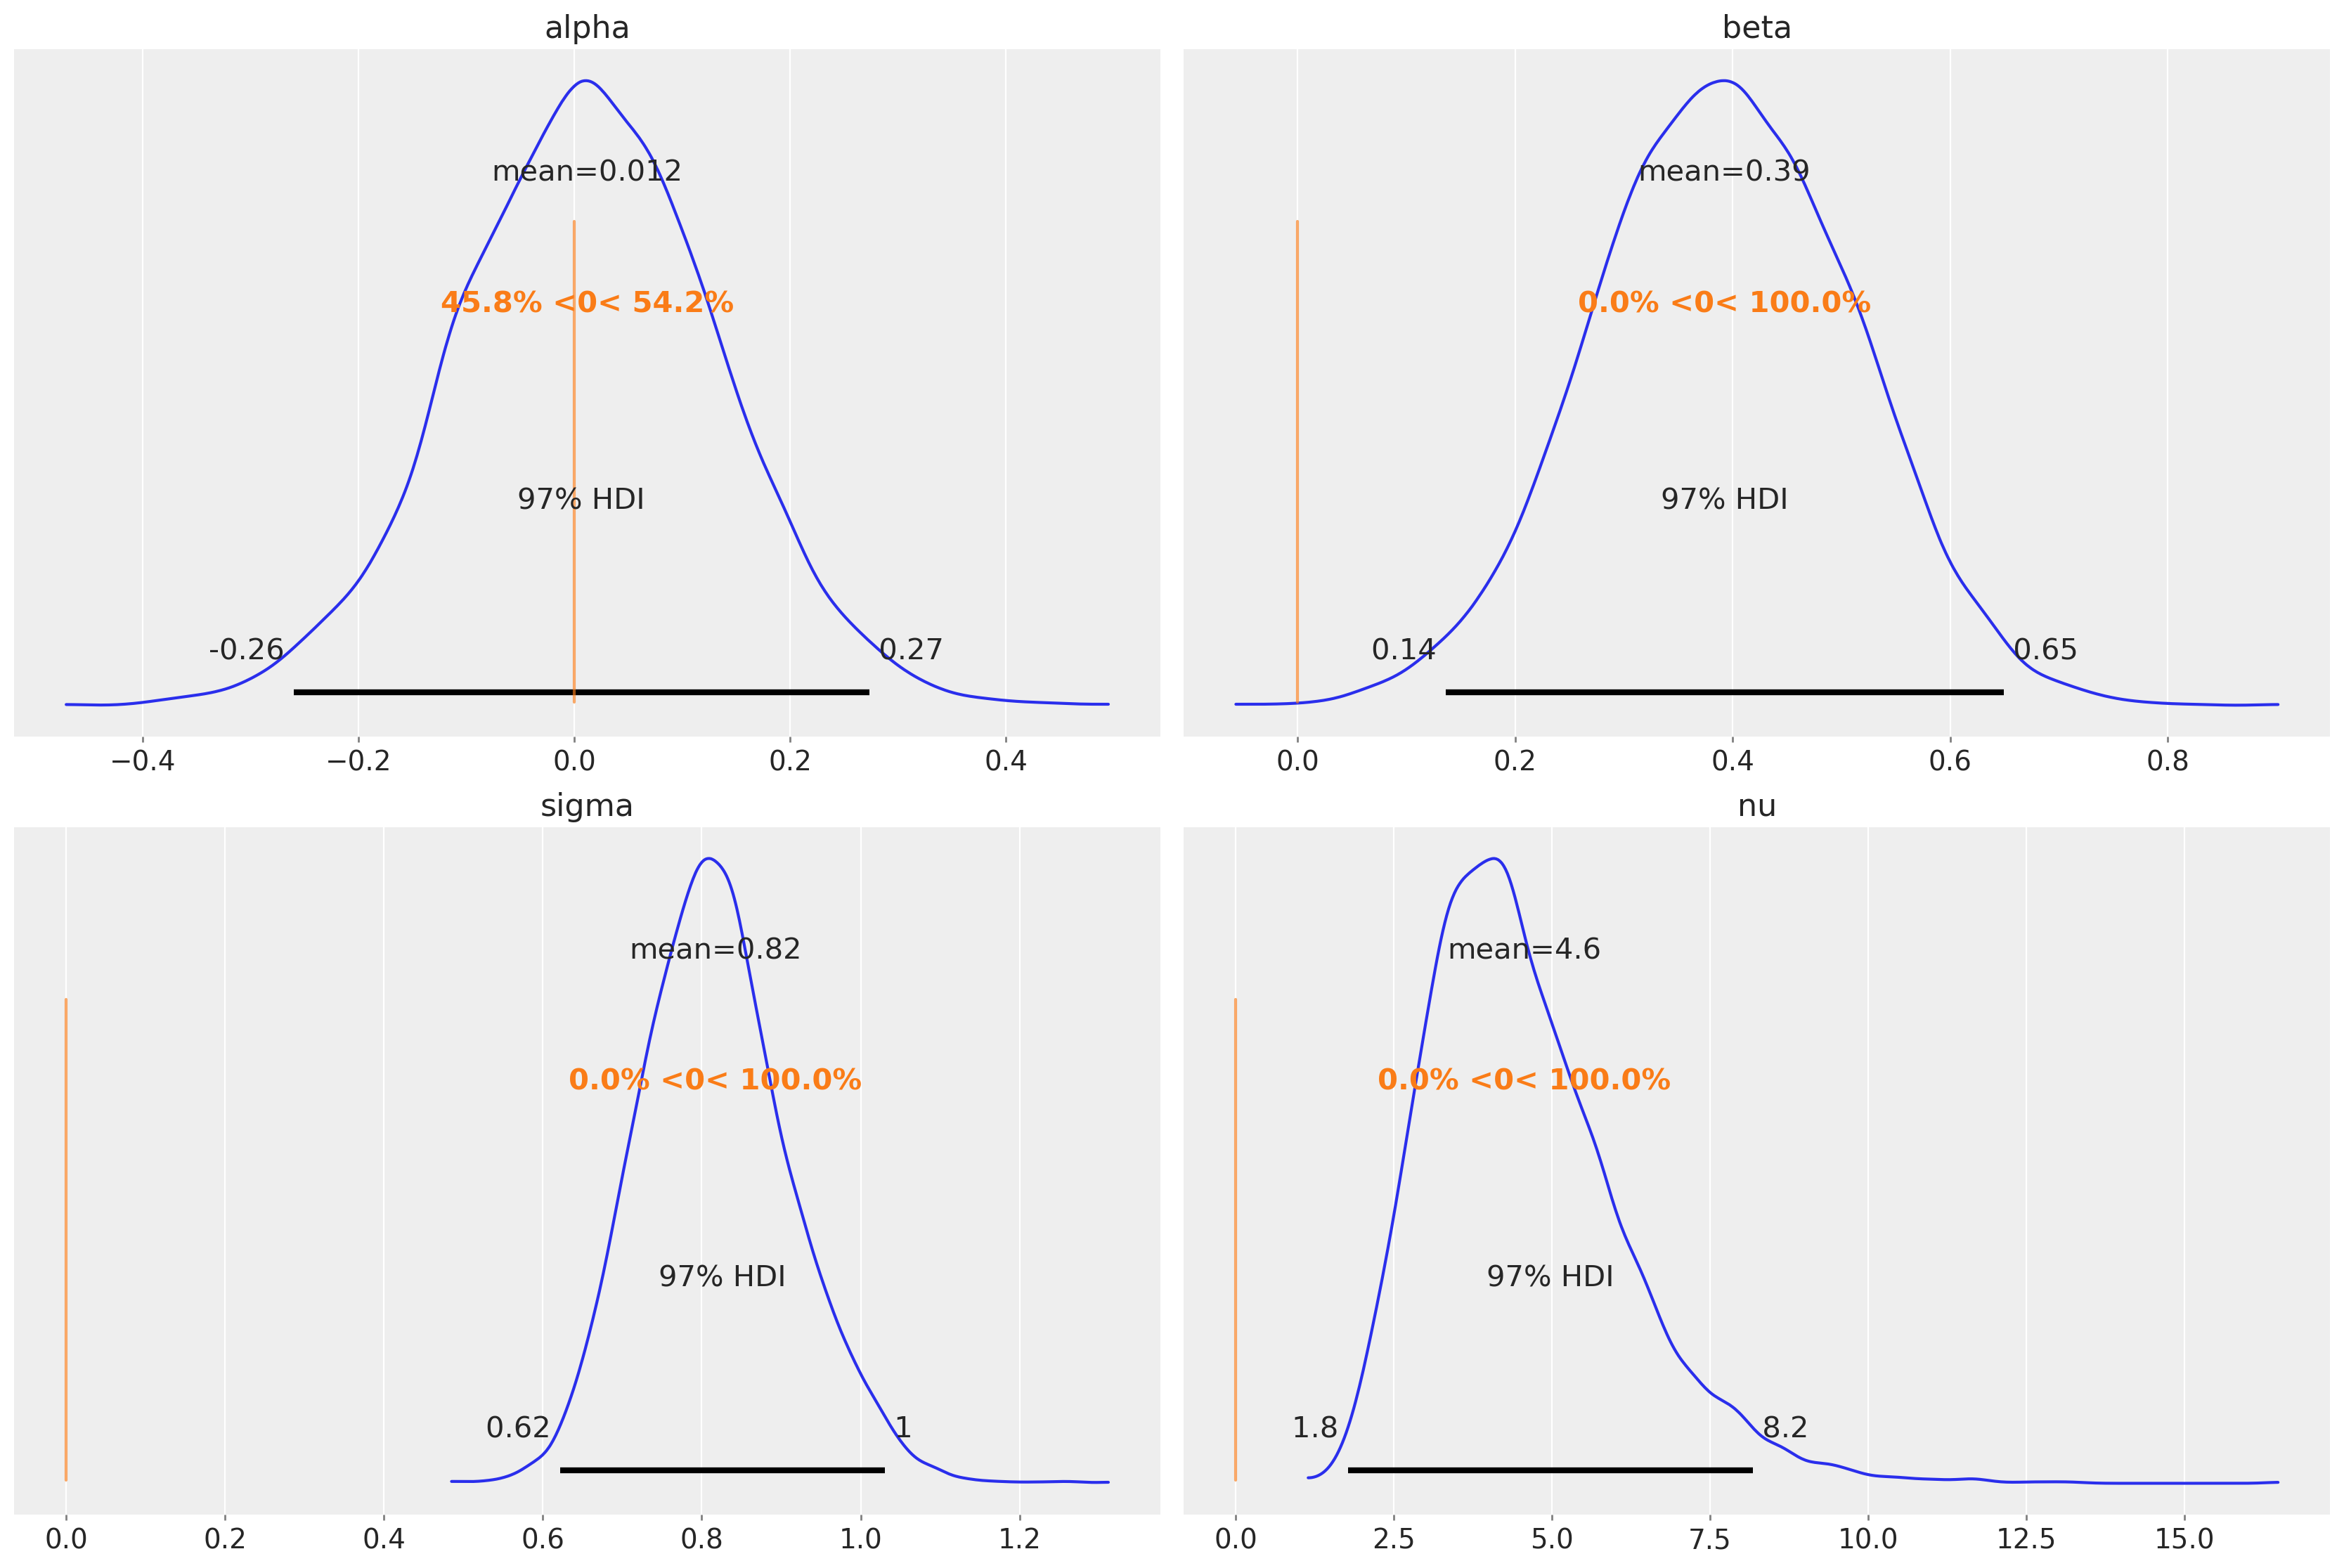

In [14]:
az.plot_posterior(idata_vpd, grid=(2,2), hdi_prob=0.97, ref_val=0.0);

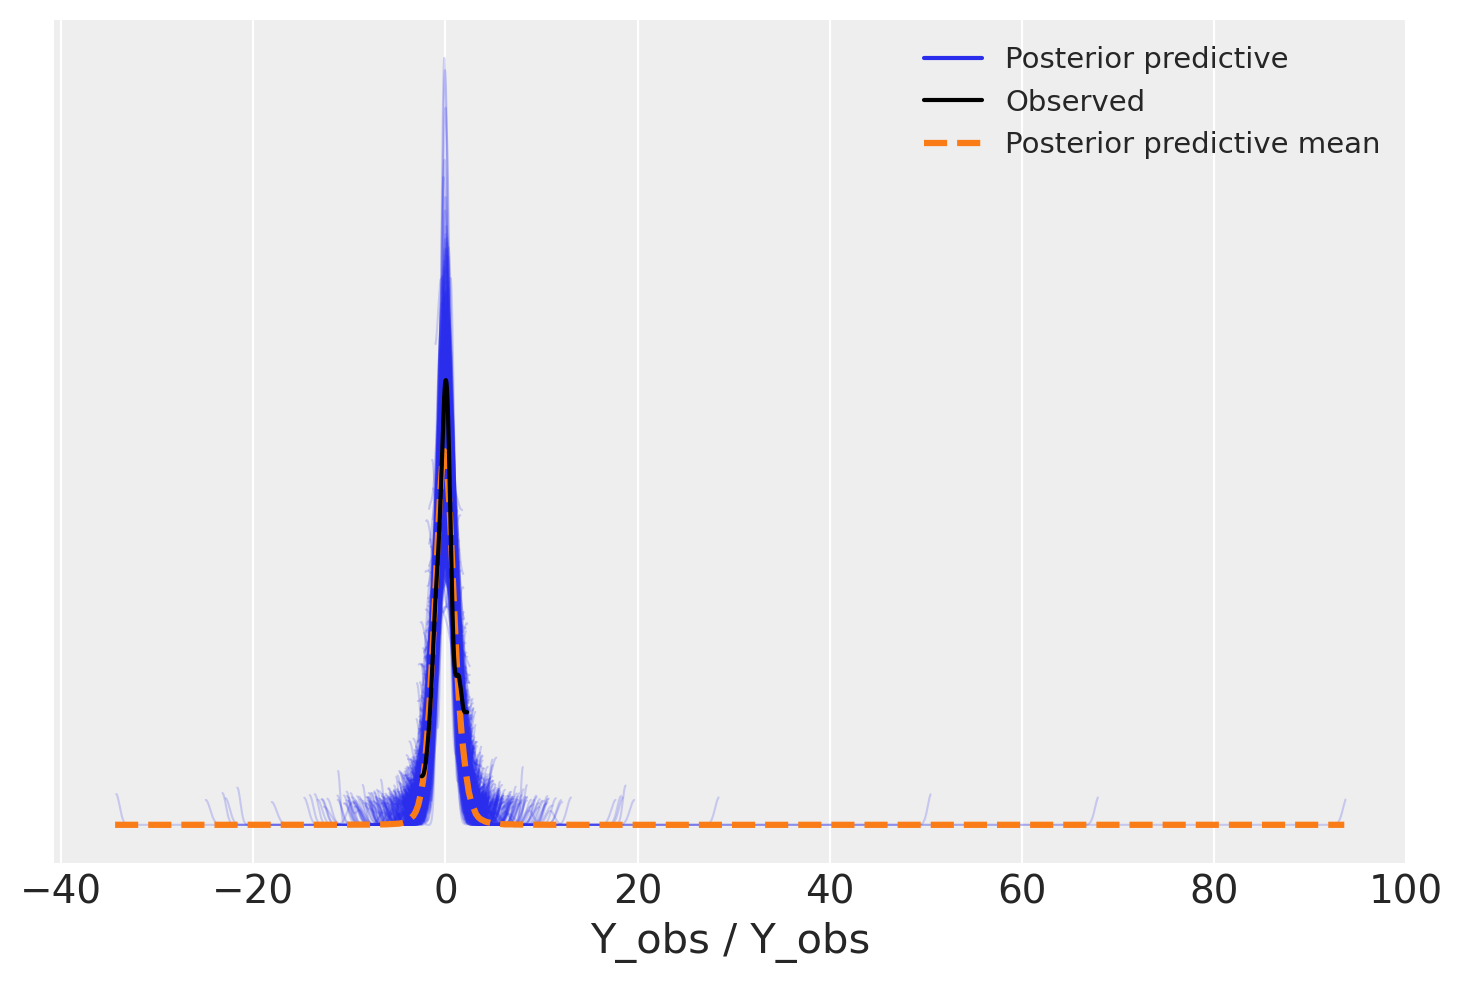

In [15]:
with linear_t_model:
    pm.sample_posterior_predictive(idata_t, extend_inferencedata=True);
az.plot_ppc(idata_t, num_pp_samples=1000);

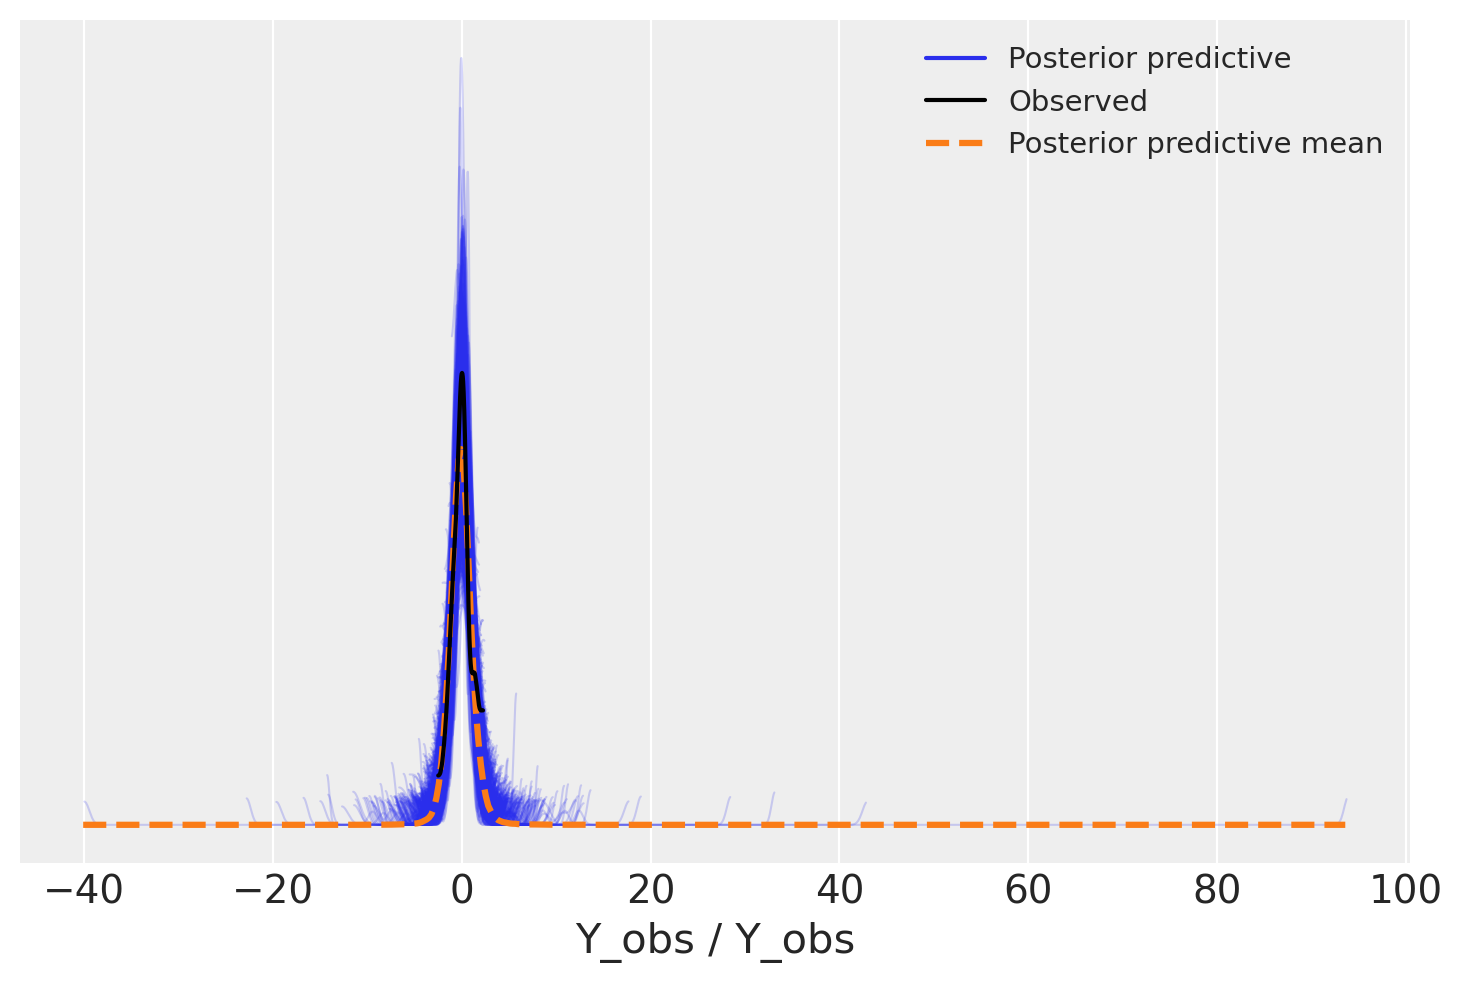

In [16]:
with linear_td_model:
    pm.sample_posterior_predictive(idata_td, extend_inferencedata=True);
az.plot_ppc(idata_t, num_pp_samples=1000);

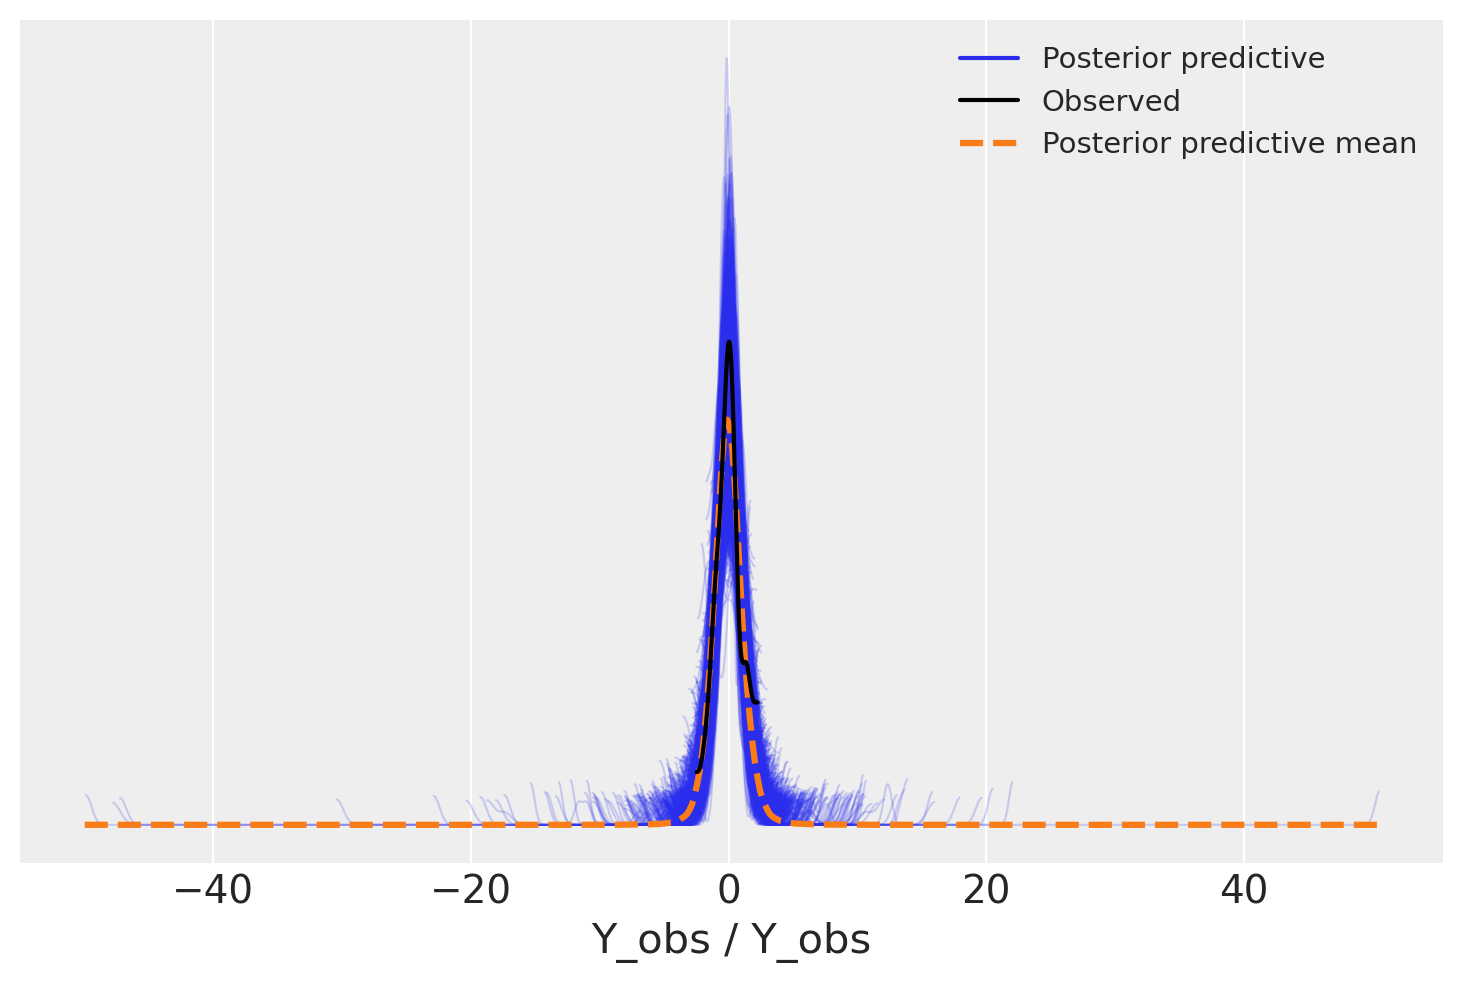

In [17]:
with linear_vpd_model:
    pm.sample_posterior_predictive(idata_vpd, extend_inferencedata=True);
az.plot_ppc(idata_t, num_pp_samples=1000);

In [18]:
with linear_t_model:
    pm.set_data({"pred": x_future})
    idata_t=pm.sample_posterior_predictive(
        idata_t,
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True
    )
    
with linear_td_model:
    pm.set_data({"pred": x_future})
    idata_td=pm.sample_posterior_predictive(
        idata_td,
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True
    )
    
with linear_vpd_model:
    pm.set_data({"pred": x_future})
    idata_vpd=pm.sample_posterior_predictive(
        idata_vpd,
        return_inferencedata=True,
        predictions=True,
        extend_inferencedata=True
    )

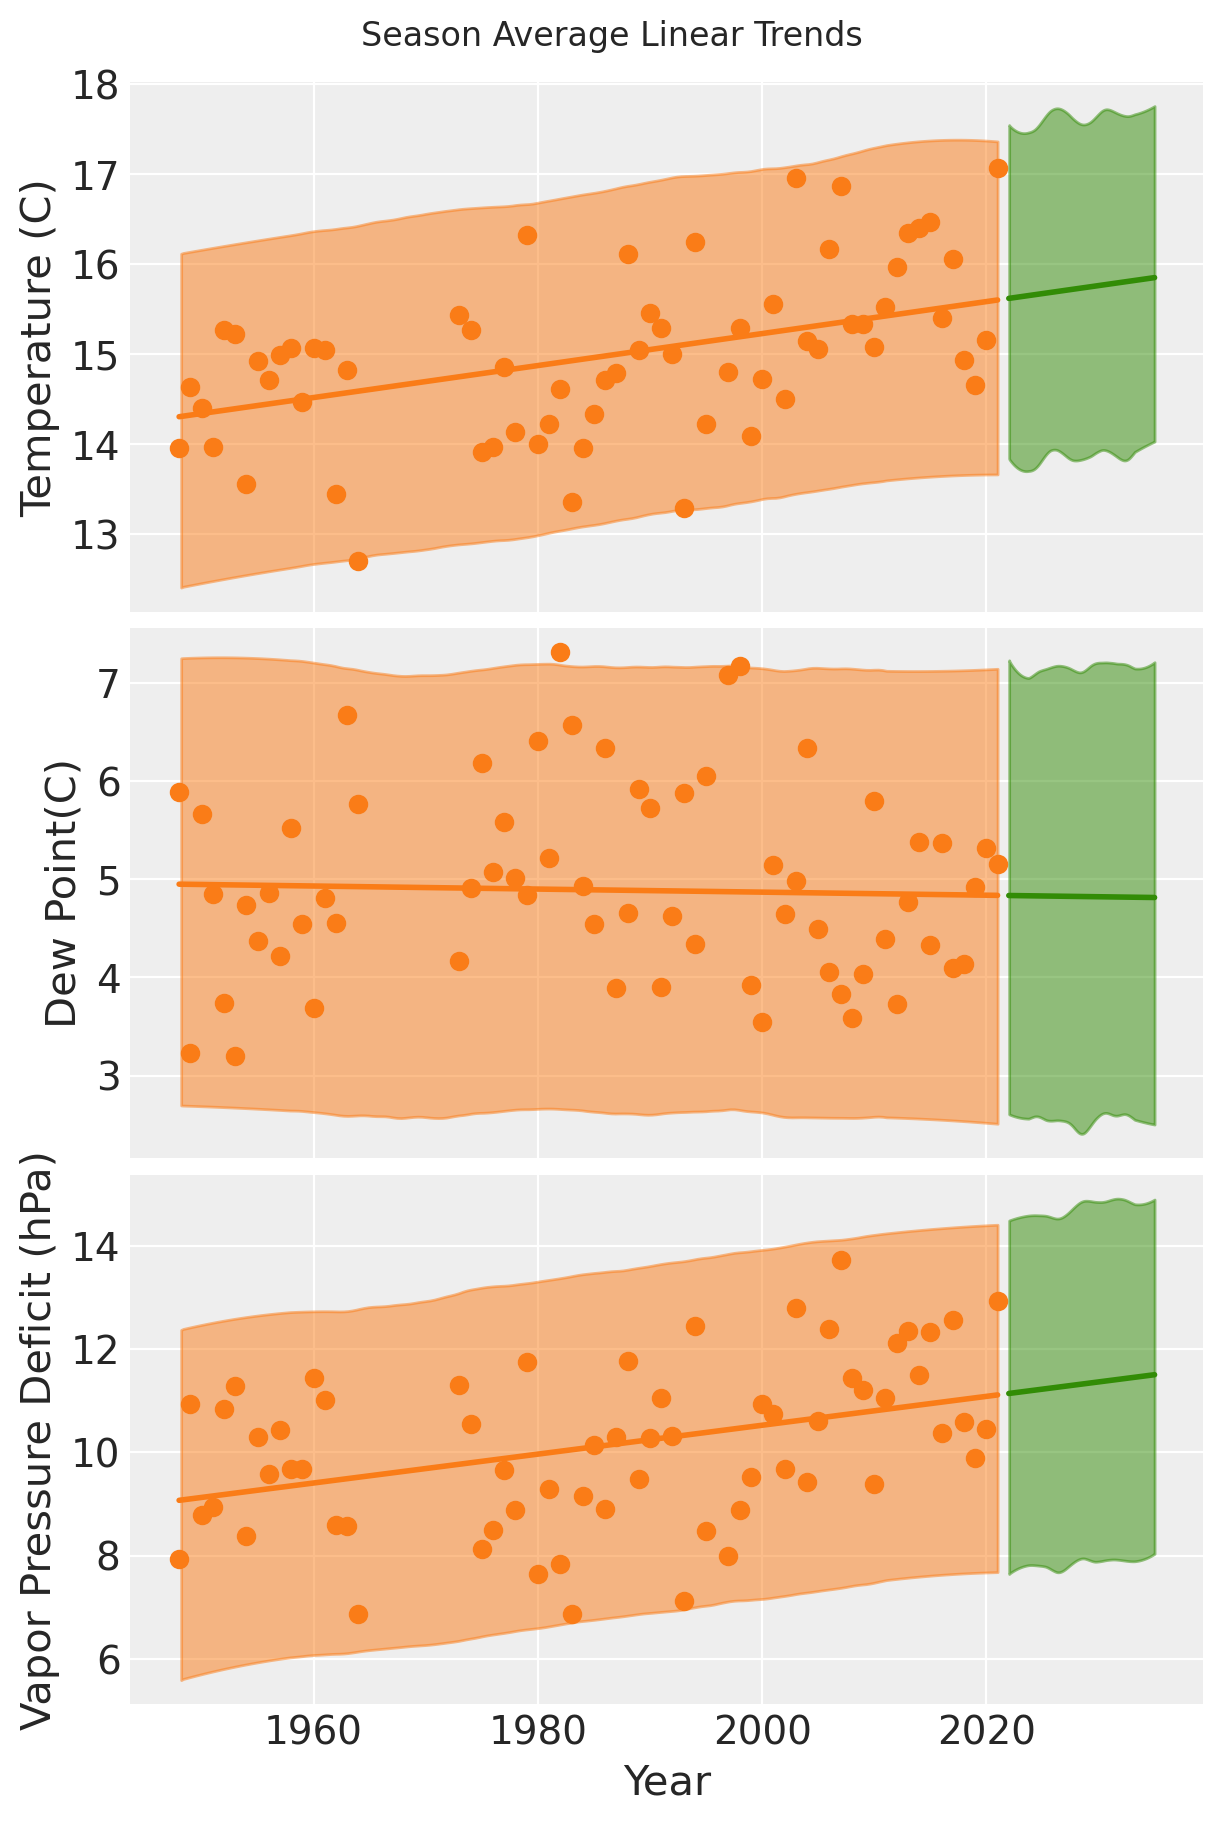

In [22]:
fig, (ax_t, ax_td, ax_vpd)  = plt.subplots(3, 1, sharex=True, figsize=(6,9))
fig.suptitle("Season Average Linear Trends");

# Plot temperature data with ranges and trends.
post_t = idata_t.posterior
mu_pp_t = post_t['alpha'] + post_t['beta'] * xr.DataArray(df['x_obs'])
mu_pp_t_future = post_t['alpha'] + post_t['beta'] * x_future

ax_t.plot(
    x_denorm(df['x_obs']), 
    y_t_denorm(mu_pp_t.mean(("chain", "draw"))), 
    label="Mean outcome", 
    color='C1', 
    alpha=1.0,
    lw=2
)

az.plot_hdi(
    x_denorm(df['x_obs']),
    y_t_denorm(idata_t.posterior_predictive['Y_obs']),
    color='C1',
    ax=ax_t
);

ax_t.scatter(
    x_denorm(df['x_obs']),
    y_t_denorm(df['y_t_obs']),
    color='C1'
);

ax_t.plot(
    x_denorm(x_future), 
    y_t_denorm(mu_pp_t_future.mean(("chain", "draw"))), 
    label="Mean outcome", 
    color='C2', 
    alpha=1.0,
    lw=2
)

az.plot_hdi(
    x_denorm(x_future),
    y_t_denorm(idata_t.predictions['Y_obs']),
    color='C2',
    ax=ax_t
);

ax_t.set_ylabel("Temperature (C)");

# Plot dew point data with ranges and trends.
post_td = idata_td.posterior
mu_pp_td = post_td['alpha'] + post_td['beta'] * xr.DataArray(df['x_obs'])
mu_pp_td_future = post_td['alpha'] + post_td['beta'] * x_future

ax_td.plot(
    x_denorm(df['x_obs']), 
    y_td_denorm(mu_pp_td.mean(("chain", "draw"))), 
    label="Mean outcome", 
    color='C1', 
    alpha=1.0,
    lw=2
)

az.plot_hdi(
    x_denorm(df['x_obs']),
    y_td_denorm(idata_td.posterior_predictive['Y_obs']),
    color='C1',
    ax=ax_td
);

ax_td.scatter(
    x_denorm(df['x_obs']),
    y_td_denorm(df['y_td_obs']),
    color='C1'
);

ax_td.plot(
    x_denorm(x_future), 
    y_td_denorm(mu_pp_td_future.mean(("chain", "draw"))), 
    label="Mean outcome", 
    color='C2', 
    alpha=1.0,
    lw=2
)

az.plot_hdi(
    x_denorm(x_future),
    y_td_denorm(idata_td.predictions['Y_obs']),
    color='C2',
    ax=ax_td
);

ax_td.set_ylabel("Dew Point(C)");

# Plot vapor pressure deficit data with ranges and trends.
post_vpd = idata_vpd.posterior
mu_pp_vpd = post_vpd['alpha'] + post_vpd['beta'] * xr.DataArray(df['x_obs'])
mu_pp_vpd_future = post_vpd['alpha'] + post_vpd['beta'] * x_future

ax_vpd.plot(
    x_denorm(df['x_obs']), 
    y_vpd_denorm(mu_pp_vpd.mean(("chain", "draw"))), 
    label="Mean outcome", 
    color='C1', 
    alpha=1.0,
    lw=2
)

az.plot_hdi(
    x_denorm(df['x_obs']),
    y_vpd_denorm(idata_vpd.posterior_predictive['Y_obs']),
    color='C1',
    ax=ax_vpd
);

ax_vpd.scatter(
    x_denorm(df['x_obs']),
    y_vpd_denorm(df['y_vpd_obs']),
    color='C1'
);

ax_vpd.plot(
    x_denorm(x_future), 
    y_vpd_denorm(mu_pp_vpd_future.mean(("chain", "draw"))), 
    label="Mean outcome", 
    color='C2', 
    alpha=1.0,
    lw=2
)

az.plot_hdi(
    x_denorm(x_future),
    y_vpd_denorm(idata_vpd.predictions['Y_obs']),
    color='C2',
    ax=ax_vpd
);

ax_vpd.set_ylabel("Vapor Pressure Deficit (hPa)");
ax_vpd.set_xlabel("Year");